In [2]:
# to add:
    # try a white balancing algo?

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from dataclasses import dataclass
from collections import deque

In [4]:
DATA_DIR = "./my-dataset/give-way/"

all_gw_dirs = sorted(os.listdir(DATA_DIR))
print(all_gw_dirs)
for i in range(0, len(all_gw_dirs)):
    all_gw_dirs[i] = os.path.join(DATA_DIR, all_gw_dirs[i])

CURRENT_DIR = 4
ORIGINAL_DATA = "the_dataset"
DOWNSCALED_DATA = "downscaled_352x288"

GIVE_WAY_DIR = os.path.join(all_gw_dirs[CURRENT_DIR], )
GIVE_WAY_SOLVED_DIR = os.path.join(all_gw_dirs[CURRENT_DIR], "solved_dataset")

RED_PX = 0
GREEN_PX = 1
BLUE_PX = 2

SIGN_MARK_COLOR = '#FF00FF'

MIN_RED_FACTOR = 1.6
MIN_WHITE_BRIGHTNESS = 70
# MAX_WHITE_RGB_VARIANCE = 20
MAX_WHITE_VARIANCE = 0.3

APPROXIMATE_PIXELS_TO_CHECK = 1000
# for the thick give way
THICK_GW_BORDER_PER_CENT = 0.356
THIN_GW_BORDER_PER_CENT = 0.72

MIN_CHUNK_SIZE = 20
# MIN_CHUNK_SIZE = 1000
MIN_CHUNK_SCORE = 0.8
MIN_TRIANGLE_ANGLE = 40

MAX_CLUMPING_VARIANCE = 10

['angled_signs', 'calibration', 'easy_thick_sign_set', 'easy_thin_sign_set', 'fun_uni_groza_set', 'single_sign_neighborhood_set']


In [5]:
# useful structs

@dataclass
class point:
    x: float
    y: float

@dataclass 
class give_way_chunk:
    top_left_point:  point
    top_right_point: point 
    bottom_point:    point

In [6]:
gw_images = []
for img_name in sorted(os.listdir(GIVE_WAY_DIR)):
    gw_images.append(np.transpose(mpimg.imread(os.path.join(GIVE_WAY_DIR, img_name)), (1, 0, 2)))
    # gw_images.append(mpimg.imread(os.path.join(GIVE_WAY_DIR, img_name)))
    
test_img = gw_images[0]
img = gw_images[0]
print(np.shape(img))
print(img.mean(axis=(0,1)))

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(img)
ax[0].set_title('Original Image')
img_mean = (img*1.0 / img.mean(axis=(0,1)))
ax[1].imshow(img_mean.clip(0, 1))
ax[1].set_title('Whitebalanced Image')
plt.show()

print(np.shape(img_mean))
print(np.max(img_mean))

# for i in range (0, len(gw_images)):
#     plt.imshow(gw_images[i])
#     plt.show()

IsADirectoryError: [Errno 21] Is a directory: './my-dataset/give-way/fun_uni_groza_set/downscaled_352x288'

In [ ]:
def point_area(p_point1, p_point2, p_point3):
    return np.abs(p_point1.x*(p_point2.y-p_point3.y) + p_point2.x*(p_point3.y-p_point1.y) + p_point3.x*(p_point1.y-p_point2.y)) / 2.0

def chunk_area(p_chunk):
    return np.abs(p_chunk.top_left_point.x*(p_chunk.top_right_point.y-p_chunk.bottom_point.y) + p_chunk.top_right_point.x*(p_chunk.bottom_point.y-p_chunk.top_left_point.y) + p_chunk.bottom_point.x*(p_chunk.top_left_point.y-p_chunk.top_right_point.y)) / 2.0


def scale_point_towards_centroid(p_point, p_centroid, p_scale_factor):
    return point(
        p_centroid.x + p_scale_factor * (p_point.x - p_centroid.x), 
        p_centroid.y + p_scale_factor * (p_point.y - p_centroid.y)
    )

def get_inner_triangle_chunk(p_chunk, p_scale):
    # Calculate the centroid of the original triangle
    centroid_x = (p_chunk.top_left_point.x + p_chunk.top_right_point.x + p_chunk.bottom_point.x) / 3
    centroid_y = (p_chunk.top_left_point.y + p_chunk.top_right_point.y + p_chunk.bottom_point.y) / 3
    centroid = point(centroid_x, centroid_y)

    # Scale the points towards the centroid
    scaled_left_point = scale_point_towards_centroid(p_chunk.top_left_point, centroid, p_scale)
    scaled_right_point = scale_point_towards_centroid(p_chunk.top_right_point, centroid, p_scale)
    scaled_bottom_point = scale_point_towards_centroid(p_chunk.bottom_point, centroid, p_scale)

    return give_way_chunk(scaled_left_point, scaled_right_point, scaled_bottom_point)

# gets what side the point is on in relation to a line
def get_side(p_point, p_vertex_p1, p_vertex_p2):
    return (p_point.x - p_vertex_p2.x) * (p_vertex_p1.y - p_vertex_p2.y) - (p_vertex_p1.x - p_vertex_p2.x) * (p_point.y - p_vertex_p2.y)

def point_in_triangle(p_point, p_point_tr_1, p_point_tr_2, p_point_tr_3):

    d1 = get_side(p_point, p_point_tr_1, p_point_tr_2)
    d2 = get_side(p_point, p_point_tr_2, p_point_tr_3)
    d3 = get_side(p_point, p_point_tr_3, p_point_tr_1)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not(has_neg and has_pos)

def is_red(p_matrix_px):
    return (
        int(p_matrix_px[RED_PX]) > MIN_RED_FACTOR * int(p_matrix_px[GREEN_PX]) and 
        int(p_matrix_px[RED_PX]) > MIN_RED_FACTOR * int(p_matrix_px[BLUE_PX])
    )

# def is_white(p_matrix_px):

#     return  (int(p_matrix_px[RED_PX]) + MAX_WHITE_RGB_VARIANCE > int(p_matrix_px[GREEN_PX]) and\
#             int(p_matrix_px[RED_PX]) - MAX_WHITE_RGB_VARIANCE < int(p_matrix_px[GREEN_PX]) and\
#             int(p_matrix_px[RED_PX]) + MAX_WHITE_RGB_VARIANCE > int(p_matrix_px[BLUE_PX]) and\
#             int(p_matrix_px[RED_PX]) - MAX_WHITE_RGB_VARIANCE < int(p_matrix_px[BLUE_PX]) and\
#             p_matrix_px[RED_PX] > MIN_WHITE_BRIGHTNESS)


def check_white_condition(red, green, blue):
    sundown_exception_facotor = 1
    if red + green + blue > 2 * MIN_WHITE_BRIGHTNESS:
        sundown_exception_facotor = 2
    
    return(
            (red + green + blue) / 3 > MIN_WHITE_BRIGHTNESS and\
            (red + MAX_WHITE_VARIANCE * red) > green and\
            (red - sundown_exception_facotor * MAX_WHITE_VARIANCE * red) < green and\
            (red + MAX_WHITE_VARIANCE * red) > blue and\
            (red - sundown_exception_facotor * MAX_WHITE_VARIANCE * red) < blue and\
            (green + MAX_WHITE_VARIANCE * green) > blue and\
            (green - MAX_WHITE_VARIANCE * green) < blue 
    )

def is_white(p_matrix_px, p_rgb_mean):
    red = int(p_matrix_px[RED_PX])
    green = int(p_matrix_px[GREEN_PX])
    blue = int(p_matrix_px[BLUE_PX])

    max_mean = np.max(p_rgb_mean)

    balanced_red = red + (1 - p_rgb_mean[RED_PX]/max_mean) * red
    balanced_green = green + (1 - p_rgb_mean[GREEN_PX]/max_mean) * green
    balanced_blue = blue + (1 - p_rgb_mean[BLUE_PX]/max_mean) * blue

    return check_white_condition(red, green, blue) \
        or check_white_condition(balanced_red, balanced_green, balanced_blue)
        

def generate_culling_rates(n, m, percentage):
    total_elements = n * m
    target_prints = round(percentage * total_elements)

    # Find the closest factors of target_prints that are less than or equal to n and m
    culling_rate_i = max(round(n / np.sqrt(target_prints)), 1)
    culling_rate_j = max(round(m / np.sqrt(target_prints)), 1)

    return culling_rate_i, culling_rate_j

# try to find a condition to filter based on shape
def has_small_angle(p_chunk):
    a_side = np.sqrt(pow(p_chunk.top_left_point.x - p_chunk.top_right_point.x, 2) + pow(p_chunk.top_left_point.y - p_chunk.top_right_point.y, 2))
    b_side = np.sqrt(pow(p_chunk.bottom_point.x - p_chunk.top_right_point.x, 2) + pow(p_chunk.bottom_point.y - p_chunk.top_right_point.y, 2))
    c_side = np.sqrt(pow(p_chunk.top_left_point.x - p_chunk.bottom_point.x, 2) + pow(p_chunk.top_left_point.y - p_chunk.bottom_point.y, 2))

    if a_side == 0 or b_side == 0 or c_side == 0:
        return True

    a_angle = np.arccos((pow(b_side, 2) + pow(c_side, 2) - pow(a_side, 2)) / (2 * b_side * c_side)) * 180 / np.pi
    b_angle = np.arccos((pow(a_side, 2) + pow(c_side, 2) - pow(b_side, 2)) / (2 * a_side * c_side)) * 180 / np.pi
    c_angle = np.arccos((pow(b_side, 2) + pow(a_side, 2) - pow(c_side, 2)) / (2 * b_side * a_side)) * 180 / np.pi

    min_triangle_condition = (a_angle < MIN_TRIANGLE_ANGLE or b_angle < MIN_TRIANGLE_ANGLE or c_angle < MIN_TRIANGLE_ANGLE)

    # if min_triangle_condition:
    #     print('unfit angle in triangle')

    return min_triangle_condition

def check_color_variance(p_pixel1, p_pixel2):
    variance = 0

    for i in range(0, len(p_pixel1)):
        variance += abs(int(p_pixel1[i]) - int(p_pixel2[i]))
    
    return (variance < MAX_CLUMPING_VARIANCE)

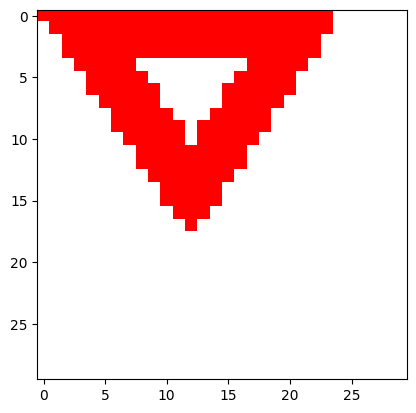

In [ ]:
# draw the gw sign to have a better idea about how the template looks

def drwa_gw(p_img, p_chunk):
    draw_percent = THICK_GW_BORDER_PER_CENT
    # filter out triangles with angle smaller than minimum
    if has_small_angle(p_chunk):
        print('bad trianlge')

    found_triangle_in_line = False

    view_win_top_left = point(min(p_chunk.top_left_point.x, p_chunk.bottom_point.x), min(p_chunk.top_left_point.y, p_chunk.top_right_point.y))
    view_win_btm_right = point(max(p_chunk.top_right_point.x, p_chunk.bottom_point.x), p_chunk.bottom_point.y)

    inner_triangle = get_inner_triangle_chunk(p_chunk, draw_percent) 

    # Draw the smaller triangle
    for i in range(int(view_win_top_left.y), int(view_win_btm_right.y)):
        found_triangle_in_line = False

        for j in range(int(view_win_top_left.x), int(view_win_btm_right.x)):
            if point_in_triangle(point(j, i), p_chunk.top_left_point, p_chunk.top_right_point, p_chunk.bottom_point):
                found_triangle_in_line = True

                if point_in_triangle(point(j, i), inner_triangle.top_left_point, inner_triangle.top_right_point, inner_triangle.bottom_point):
                    p_img[i][j][RED_PX] = 255
                    p_img[i][j][GREEN_PX] = 255
                    p_img[i][j][BLUE_PX] = 255

                else:
                    p_img[i][j][RED_PX] = 255
                    p_img[i][j][GREEN_PX] = 0
                    p_img[i][j][BLUE_PX] = 0

            # if found triangle in line and then no longer triangle, to the end of line will not find triangle again 
            elif found_triangle_in_line:
                break

def whiteout_img(p_img):
    for i in range(0, len(p_img)):
        for j in range(0, len(p_img[0])):
            p_img[i][j][RED_PX] = 255
            p_img[i][j][BLUE_PX] = 255
            p_img[i][j][GREEN_PX] = 255

# p_image = test_img[0:100, 0:100].copy()
# whiteout_img(p_image)
# drwa_gw(p_image, give_way_chunk(point(10, 10), point(50, 10), point(30, 100)))

# plt.imshow(p_image)


p_image = gw_images[0][0:30, 0:30].copy()
whiteout_img(p_image)
drwa_gw(p_image, give_way_chunk(point(0, 0), point(24, 0), point(12, 18)))

plt.imshow(p_image)
    

In [ ]:
def generate_red_spectrum():
    spectrum = []
    step = 1  # step size for iterating through color values
    for r in range(0, 256, step):
        for g in range(0, 256, step):
            for b in range(0, 256, step):
                color = [r, g, b]
                if is_white(color, [1, 1, 1]):
                    spectrum.append(color)
    
    return np.array(spectrum)

def plot_red_spectrum(spectrum):
    # Create an empty image canvas
    plt.figure(figsize=(8, 8))
    
    # Plot the colors that fit the "red" condition
    plt.scatter(spectrum[:, 1], spectrum[:, 2], c=spectrum / 255.0, s=20)
    
    plt.title('Colors That Fit the "Red" Condition')
    plt.xlabel('Green Channel')
    plt.ylabel('Blue Channel')
    plt.grid(False)
    plt.show()

# Generate and plot the spectrum
# red_spectrum = generate_red_spectrum()
# plot_red_spectrum(red_spectrum)

In [ ]:
# refactored check for sign, that does not print output and uses a method based around points on triangle
def check_for_gw(p_img, p_chunk, p_label_mat, p_mean_px_vals):
	# filter out triangles with angle smaller than minimum
	if has_small_angle(p_chunk):
		return 0

	thin_red_score = 0
	thin_white_score = 0

	thick_red_score = 0
	thick_white_score = 0

	pixels_checked = 0

	found_triangle_in_line = False

	view_win_top_left = point(min(p_chunk.top_left_point.x, p_chunk.bottom_point.x), min(p_chunk.top_left_point.y, p_chunk.top_right_point.y))
	view_win_btm_right = point(max(p_chunk.top_right_point.x, p_chunk.bottom_point.x), p_chunk.bottom_point.y)

	culling_rate_i = 1
	culling_rate_j = 1 

	# this optimisation makes everything slower for some reason?

	# triangle_area = point_area(p_chunk.top_left_point, p_chunk.top_right_point, p_chunk.bottom_point)
	# pixels_to_show_pc = 1

	# if APPROXIMATE_PIXELS_TO_CHECK < triangle_area:
	# 	pixels_to_show_pc = max(APPROXIMATE_PIXELS_TO_CHECK/triangle_area, 0.01)

	# rect_height = int(view_win_btm_right.y) - int(view_win_top_left.y)  
	# rect_width = int(view_win_btm_right.x) - int(view_win_top_left.x)  
	# culling_rate_i, culling_rate_j = generate_culling_rates(rect_height, rect_width, pixels_to_show_pc)

	thin_inner_triangle = get_inner_triangle_chunk(p_chunk, THIN_GW_BORDER_PER_CENT) 
	thick_inner_triangle = get_inner_triangle_chunk(p_chunk, THICK_GW_BORDER_PER_CENT) 


	# Draw the smaller triangle
	for i in range(int(view_win_top_left.y), int(view_win_btm_right.y), culling_rate_i):
		found_triangle_in_line = False

		for j in range(int(view_win_top_left.x), int(view_win_btm_right.x), culling_rate_j):
			if point_in_triangle(point(j, i), p_chunk.top_left_point, p_chunk.top_right_point, p_chunk.bottom_point):
				found_triangle_in_line = True
				pixels_checked += 1

				# check for thin border
				if point_in_triangle(point(j, i), thin_inner_triangle.top_left_point, thin_inner_triangle.top_right_point, thin_inner_triangle.bottom_point):
					if is_white(p_img[i][j], p_mean_px_vals) and (p_label_mat[i][j] == 0):
						thin_white_score += 1
				else:
					if p_label_mat[i][j] != 0:
						thin_red_score += 1

				# and check for thick border
				if point_in_triangle(point(j, i), thick_inner_triangle.top_left_point, thick_inner_triangle.top_right_point, thick_inner_triangle.bottom_point):
					if is_white(p_img[i][j], p_mean_px_vals) and (p_label_mat[i][j] == 0):
						thick_white_score += 1
				else:
					if p_label_mat[i][j] != 0:
						thick_red_score += 1

			# if found triangle in line and then no longer triangle, to the end of line will not find triangle again 
			elif found_triangle_in_line:
				break
	
	# print("checked", pixels_checked, "of", triangle_area, pixels_checked/triangle_area, "percent")
	#get final score for thin
	thin_white_area = chunk_area(thin_inner_triangle)
	thin_red_area = (chunk_area(p_chunk) - thin_white_area) 
	thin_white_checked = thin_white_area / (thin_white_area + thin_red_area) * pixels_checked
	thin_red_checked = pixels_checked - thin_white_checked
	final_thin_score = (min(thin_white_score / thin_white_checked, 1) + min(thin_red_score / thin_red_checked, 1)) / 2

	#get final score for thick 
	thick_white_area = chunk_area(thick_inner_triangle)
	thick_white_area = chunk_area(thick_inner_triangle)
	thick_red_area = (chunk_area(p_chunk) - thick_white_area) 
	thick_white_checked = thick_white_area / (thick_white_area + thick_red_area) * pixels_checked
	thick_red_checked = pixels_checked - thick_white_checked
	final_thick_score = (min(thick_white_score / thick_white_checked, 1) + min(thick_red_score / thick_red_checked, 1)) / 2

	round_print = 4
	print( 	"thin: red:", round(thin_red_score/thin_red_checked, round_print), 
	   		"\twhite:", round(thin_white_score/thin_white_checked, round_print),
			"\tscore:", round(final_thin_score, round_print))

	print( 	"thick: red:", round(thick_red_score/thick_red_checked, round_print),
			"\twhite:", round(thick_white_score/thick_white_checked, round_print),
			"\tscore:", round(final_thick_score, round_print))

	return max(final_thin_score, final_thick_score)

In [ ]:
def plot_triangle(p_img, p_chunk, p_score):
    plt.figure(dpi=300)
    plt.imshow(p_img)
    plt.axis('off')

    plt.plot([p_chunk.top_left_point.x, p_chunk.top_right_point.x], [p_chunk.top_left_point.y, p_chunk.top_right_point.y], color=SIGN_MARK_COLOR, linewidth=0.3)
    plt.plot([p_chunk.top_left_point.x, p_chunk.bottom_point.x], [p_chunk.top_left_point.y, p_chunk.bottom_point.y], color=SIGN_MARK_COLOR, linewidth=0.3) 
    plt.plot([p_chunk.top_right_point.x, p_chunk.bottom_point.x], [p_chunk.top_right_point.y, p_chunk.bottom_point.y], color=SIGN_MARK_COLOR, linewidth=0.3)

    plt.text(   (p_chunk.top_left_point.x + p_chunk.top_right_point.x) / 2,
                min(p_chunk.top_left_point.y, p_chunk.top_right_point.y),
                str(round(p_score, 2)), fontsize=3, color=SIGN_MARK_COLOR, 
                ha='center', va='bottom', fontweight='bold'
            )

    plt.show()

thin: red: 1.0169 	white: 0.2621 	score: 0.6311
thick: red: 0.9866 	white: 0.9104 	score: 0.9485


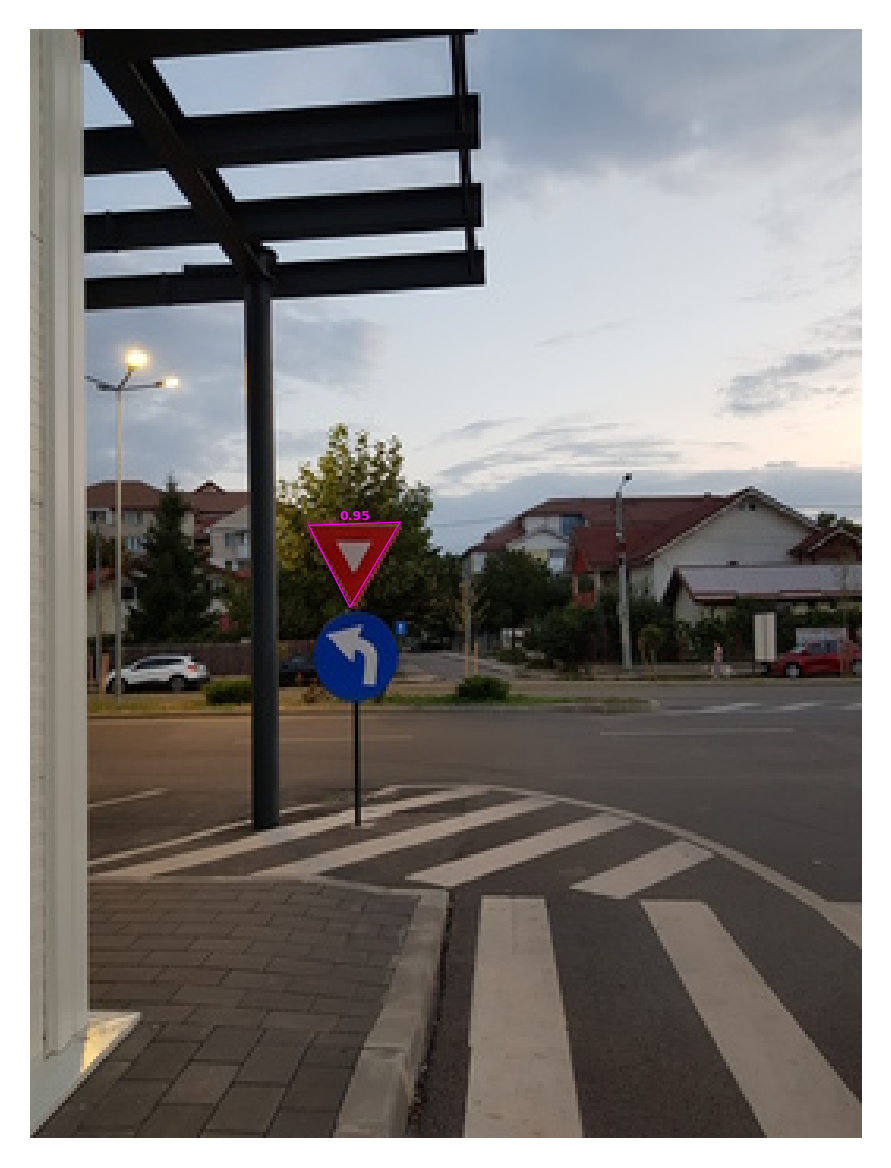

thin: red: 0.8103 	white: 0.0 	score: 0.4052
thick: red: 0.782 	white: 0.0 	score: 0.391


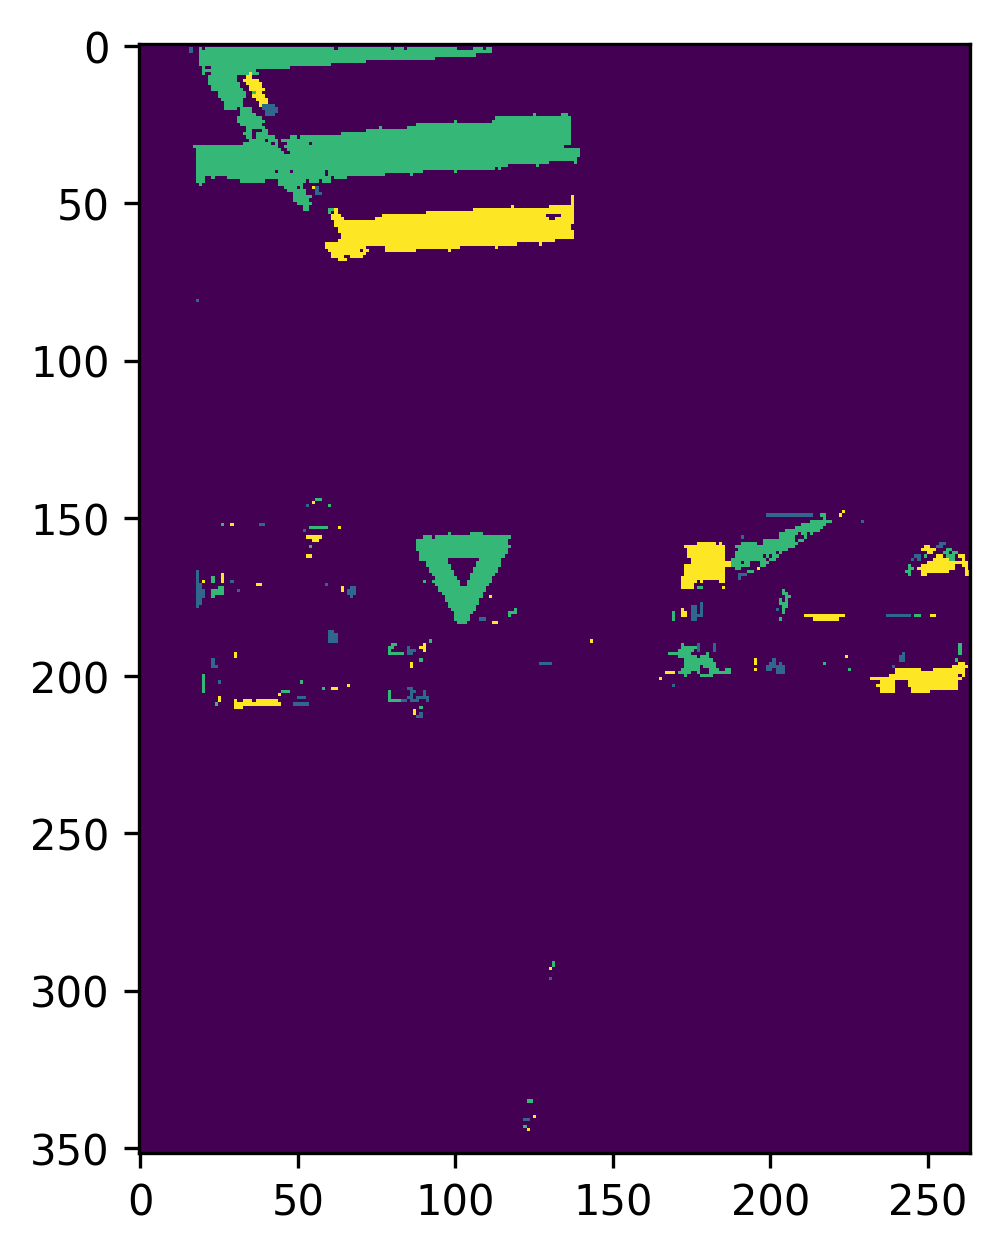

np.float64(0.9485027884243711)

In [ ]:
def fill_in_shape(p_img, p_label_mat, p_label, p_x, p_y, p_mean_px_vals):
    gw_chunk = give_way_chunk(point(p_x, p_y), point(p_x, p_y), point(p_x, p_y))

    chunk_size = 1 
    p_fronteer = deque([]) 

    p_fronteer.append((p_y, p_x))

    current_node = 0

    while len(p_fronteer) > 0:
    # while len(p_fronteer) > current_node:
        curr_y = int(p_fronteer[current_node][0])
        curr_x = int(p_fronteer[current_node][1])

        if not(curr_y >= len(p_img) - 1 or curr_x >= len(p_img[0]) - 1 or curr_y <= 1 or curr_x <= 1):
            p_label_mat[curr_y][curr_x] = p_label
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if not((i == 0 and j == 0) or (i != 0 and j != 0)):
                        if (is_red(p_img[curr_y + i][curr_x + j]) or check_color_variance(p_img[curr_y][curr_x], p_img[curr_y + i][curr_x + j])) and p_label_mat[curr_y + i][curr_x + j] == 0:
                        # if (is_red(p_img[curr_y + i][curr_x  + j])) and p_label_mat[curr_y + i][curr_x + j] == 0:
                            p_label_mat[curr_y + i][curr_x + j] = p_label

                            p_fronteer.append((curr_y + i, curr_x + j))
                            chunk_size += 1

                            if(curr_x + j < gw_chunk.top_left_point.x):
                                gw_chunk.top_left_point.y = curr_y + i
                                gw_chunk.top_left_point.x = curr_x + j 

                            if(curr_x + j > gw_chunk.top_right_point.x):
                                gw_chunk.top_right_point.y = curr_y + i
                                gw_chunk.top_right_point.x = curr_x + j

                            if(curr_y + i > gw_chunk.bottom_point.y):
                                gw_chunk.bottom_point.y = curr_y + i
                                gw_chunk.bottom_point.x = curr_x + j

        # current_node += 1 
        p_fronteer.popleft()
    
    if chunk_size >= MIN_CHUNK_SIZE:
        chunk_score = check_for_gw(p_img, gw_chunk, p_label_mat, p_mean_px_vals)
        if chunk_score > MIN_CHUNK_SCORE:
            # print("similitude:", chunk_score)
            plot_triangle(p_img, gw_chunk, chunk_score)
            return chunk_score
    
    return 0


def detect_gw(p_img):
    mean_px_vals = p_img.mean(axis=(0,1))
    
    label_mat = np.zeros((len(p_img), len(p_img[0])))
    total_labels = 3 
    starting_label = 1 
    current_label = starting_label
    
    best_score = 0

    for i in range(1, len(p_img) - 2):
        for j in range(1, len(p_img[0]) - 2):
            if is_red(p_img[i][j]) and label_mat[i][j] == 0:
                current_score= fill_in_shape(p_img, label_mat, current_label, j, i, mean_px_vals)
                if current_score > best_score:
                    best_score = current_score

                current_label += 1
                if current_label > total_labels:
                    current_label = starting_label
    plt.figure(dpi=300)
    plt.imshow(label_mat)
    plt.show()
    return best_score

detect_gw(gw_images[8])

# normal case: 2s
# worst case: 18s

In [ ]:
def check_red(p_img):
    trim = 0

    for i in range(trim, len(p_img) - trim):
        for j in range(trim, len(p_img[0]) - trim):
            if is_red(p_img[i][j]):
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 0
                p_img[i][j][BLUE_PX] = 0

            if is_white(p_img[i][j]): 
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 255 
                p_img[i][j][BLUE_PX] = 255 

def show_color_funtions():
    for i in range(0, len(gw_images)):
        original_img = gw_images[i].copy()
        img = gw_images[i].copy()

        check_red(img)

        plt.figure(figsize=(8, 5), dpi = 200)
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(original_img)

        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# show_color_funtions()

15
current_img:


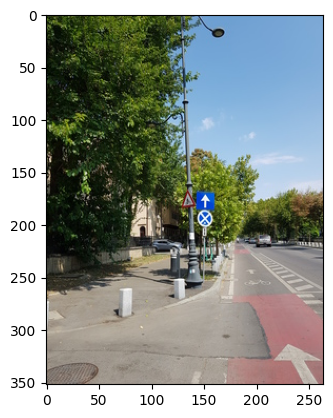

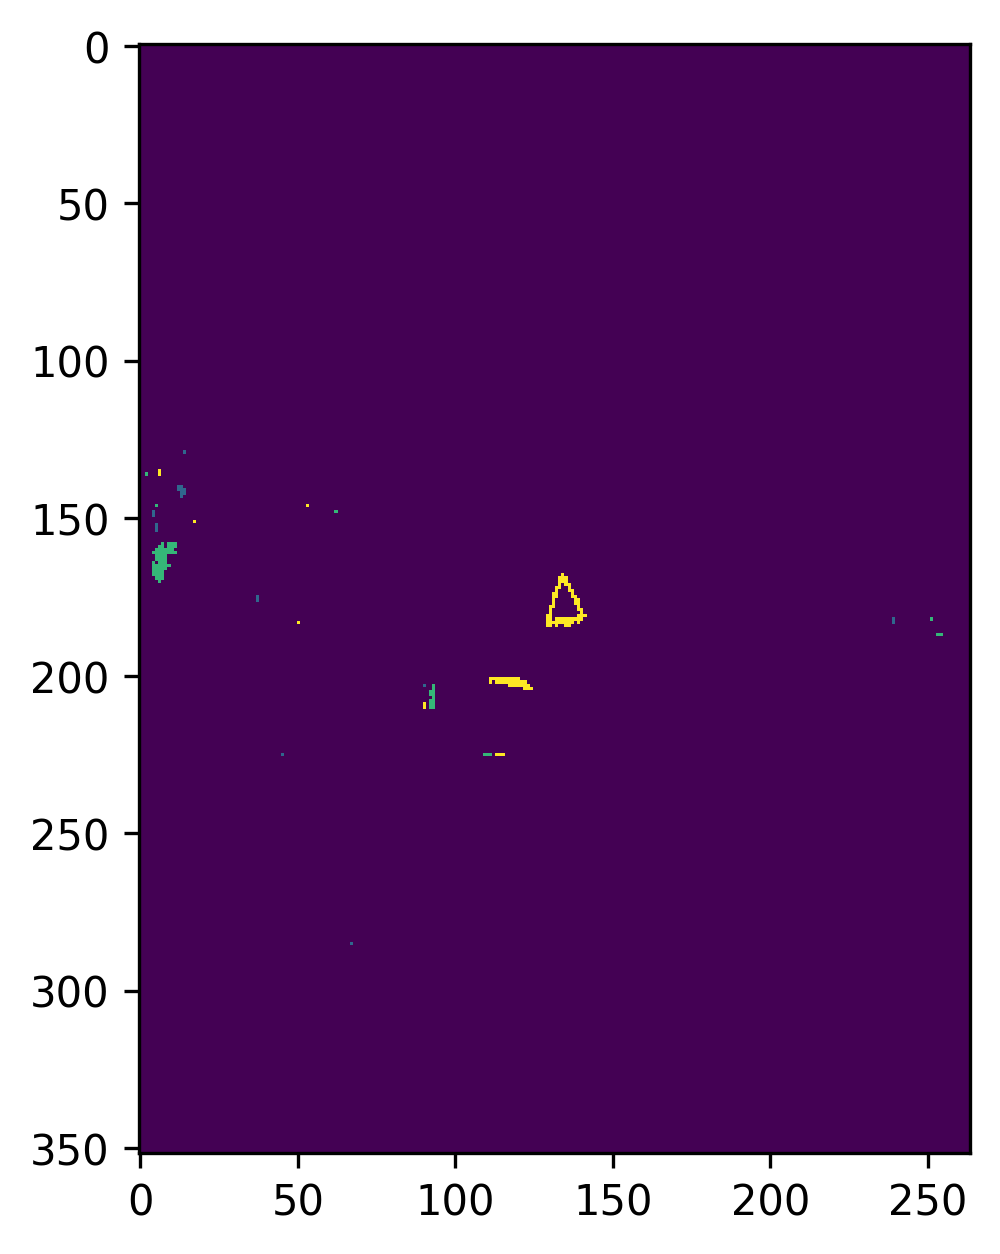

current_img:


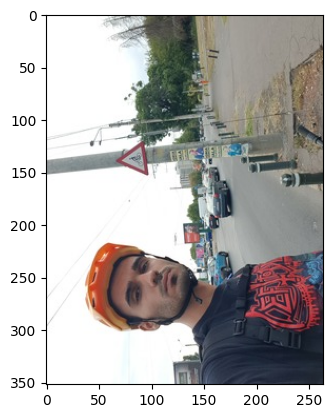

thin: red: 0.476 	white: 0.4778 	score: 0.4769
thick: red: 0.3961 	white: 0.5101 	score: 0.4531


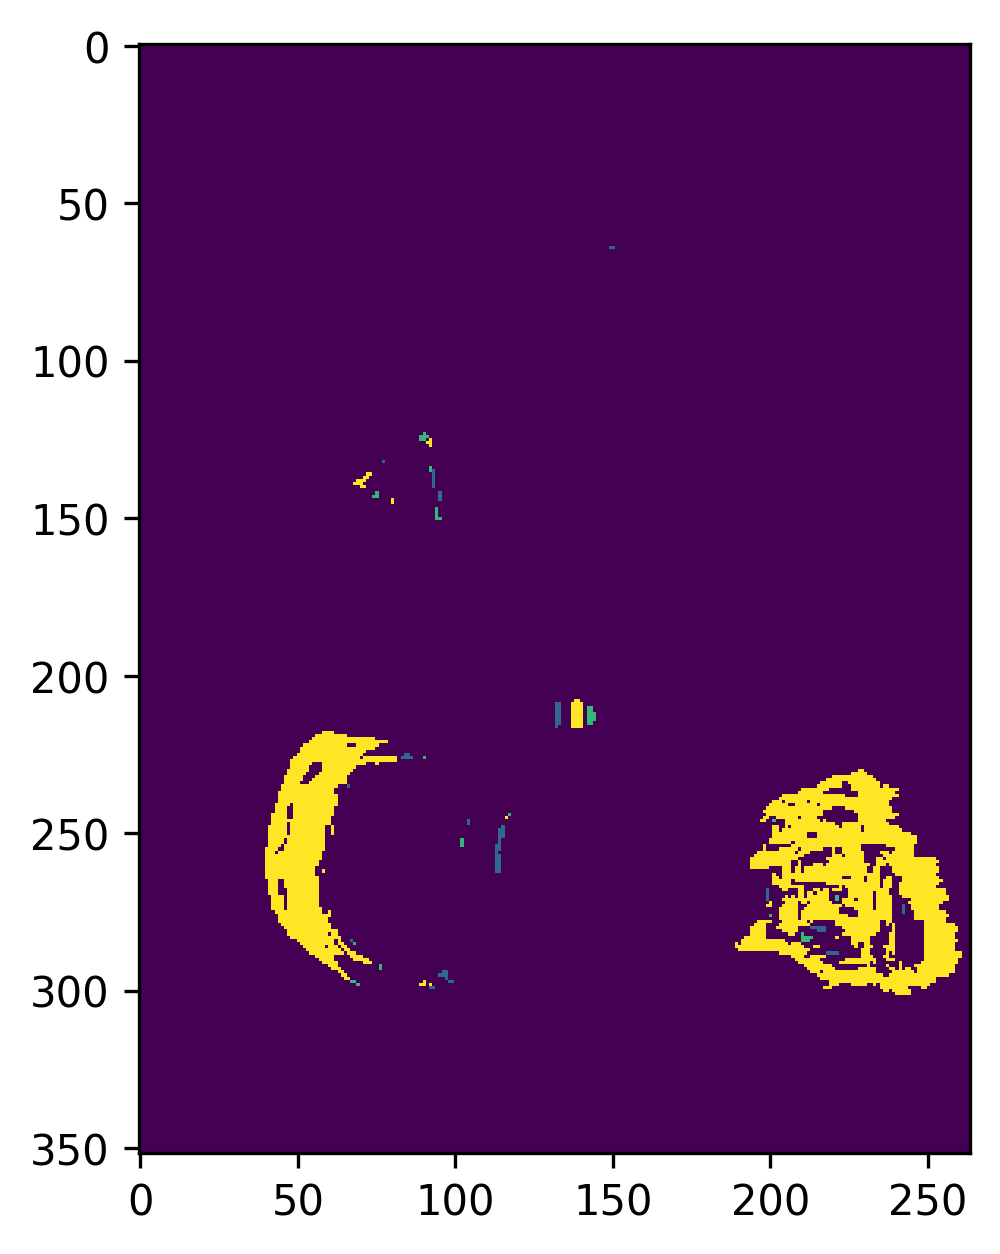

current_img:


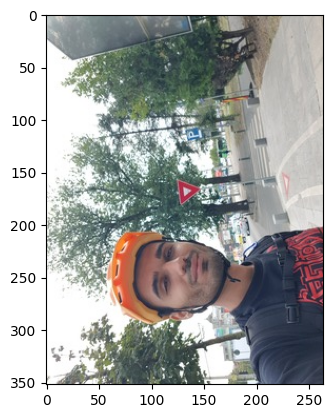

thin: red: 1.0143 	white: 0.4767 	score: 0.7384
thick: red: 0.8621 	white: 0.9976 	score: 0.9299


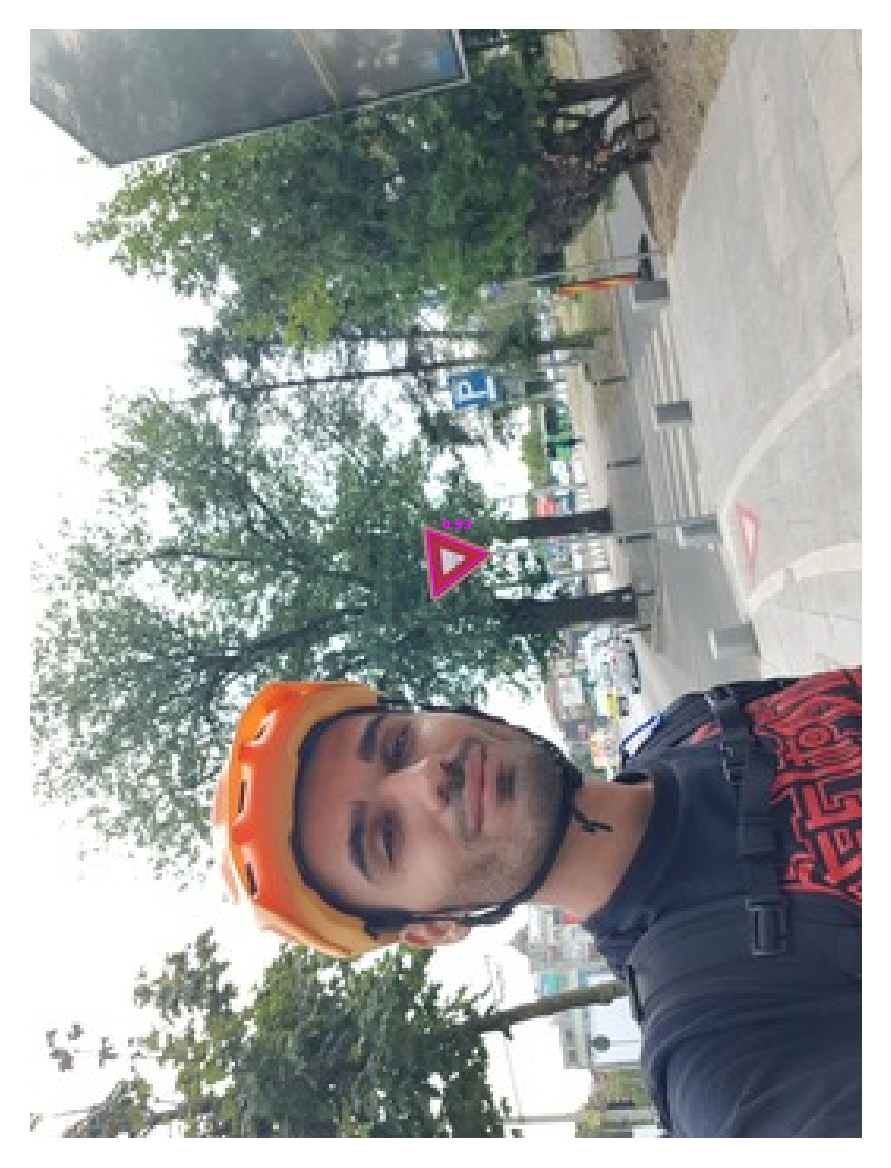

thin: red: 0.5475 	white: 0.1223 	score: 0.3349
thick: red: 0.6336 	white: 0.0455 	score: 0.3395


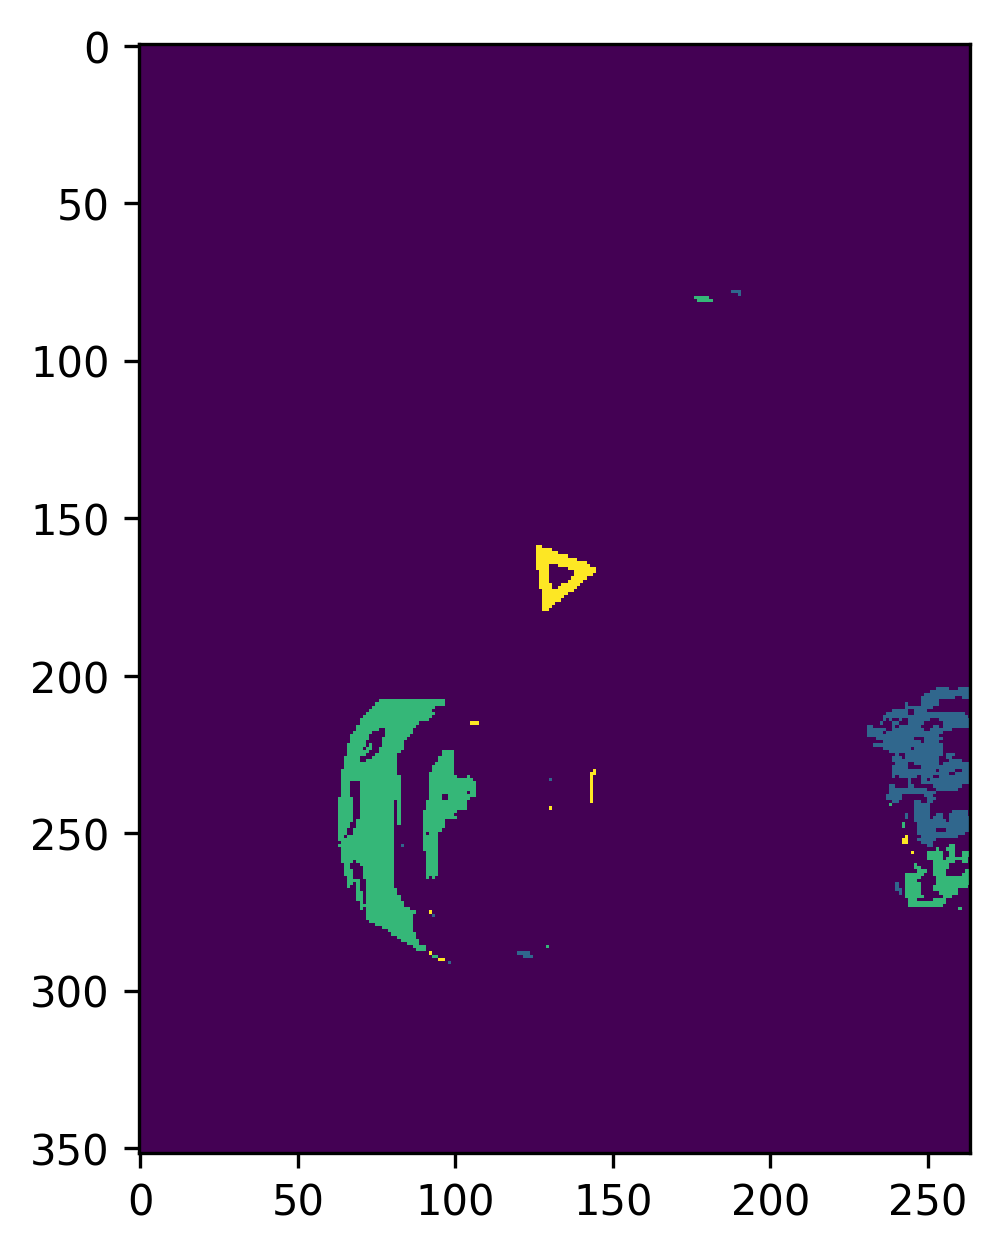

current_img:


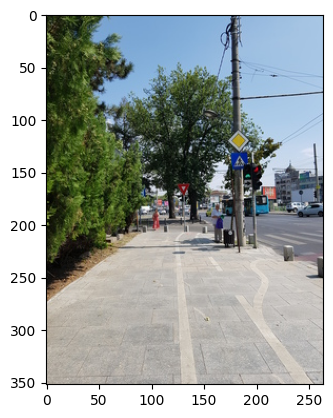

thin: red: 0.9228 	white: 0.0 	score: 0.4614
thick: red: 1.0179 	white: 0.0 	score: 0.5
thin: red: 1.0382 	white: 0.3086 	score: 0.6543
thick: red: 0.9619 	white: 1.2625 	score: 0.981


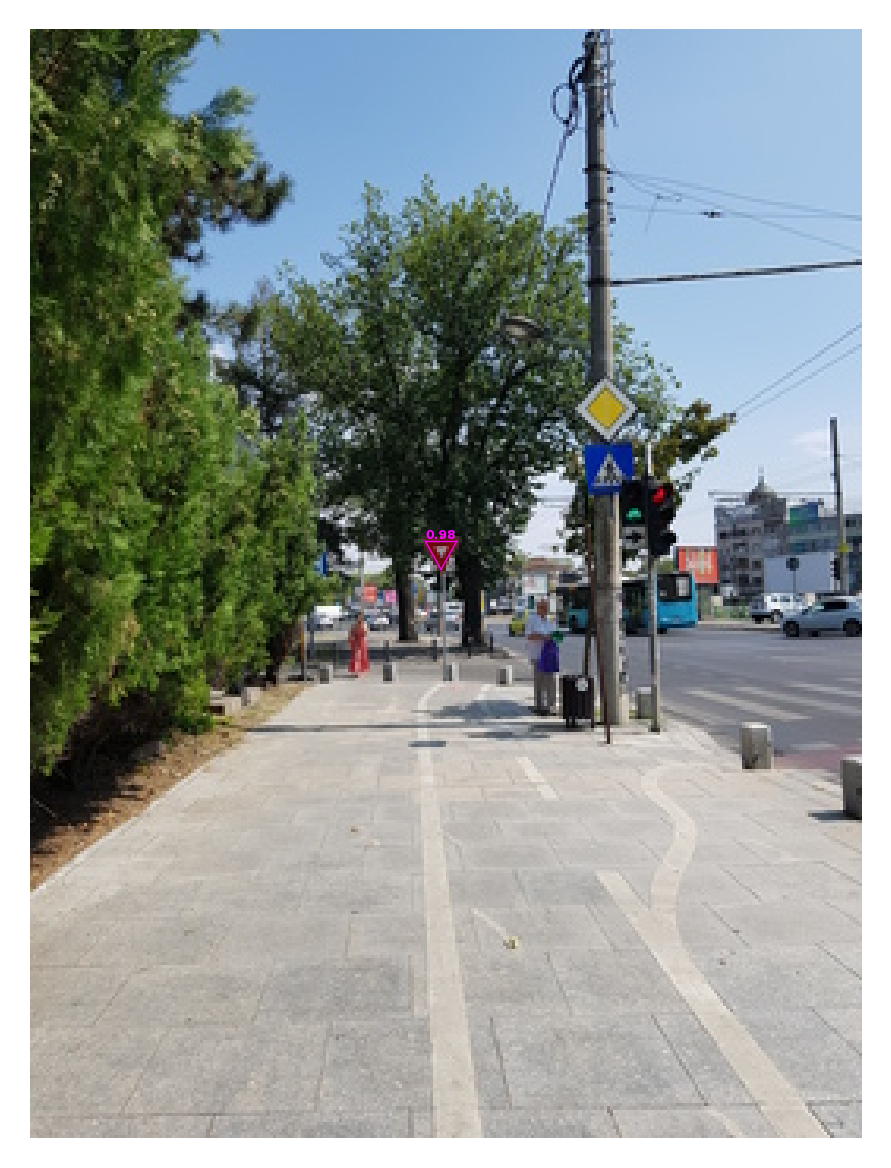

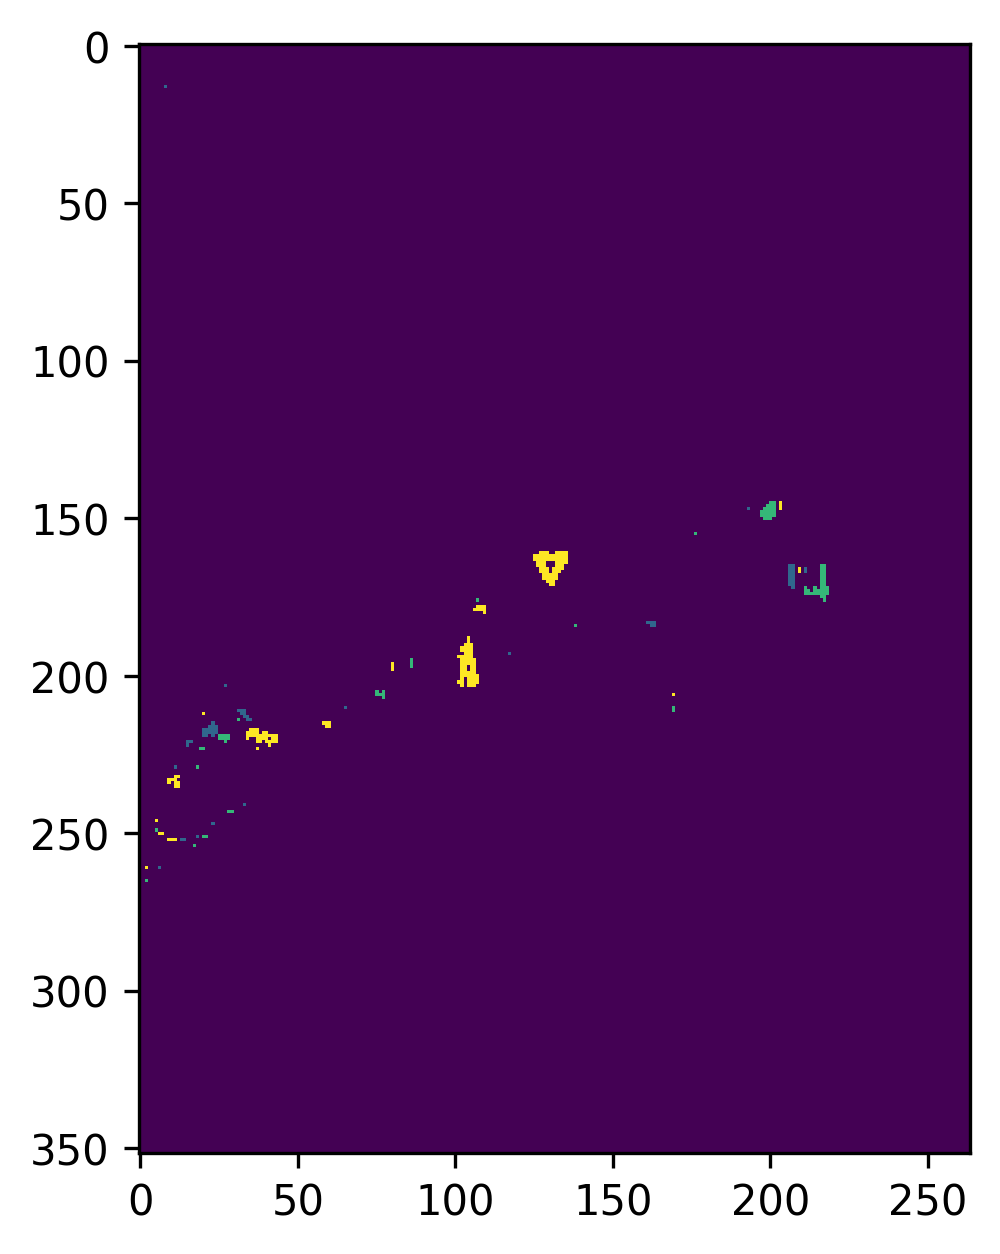

current_img:


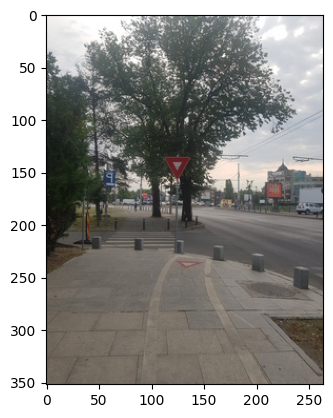

thin: red: 1.0193 	white: 0.3069 	score: 0.6534
thick: red: 0.9629 	white: 0.8608 	score: 0.9119


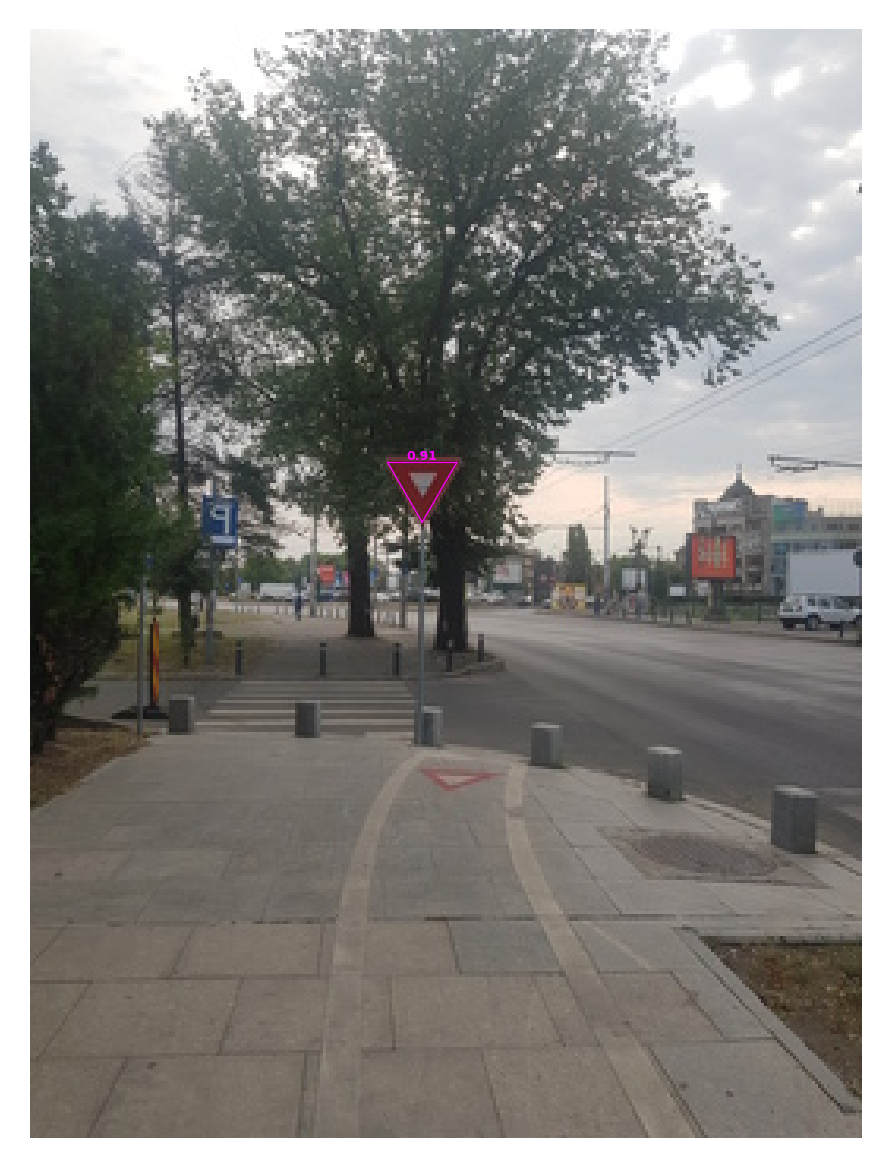

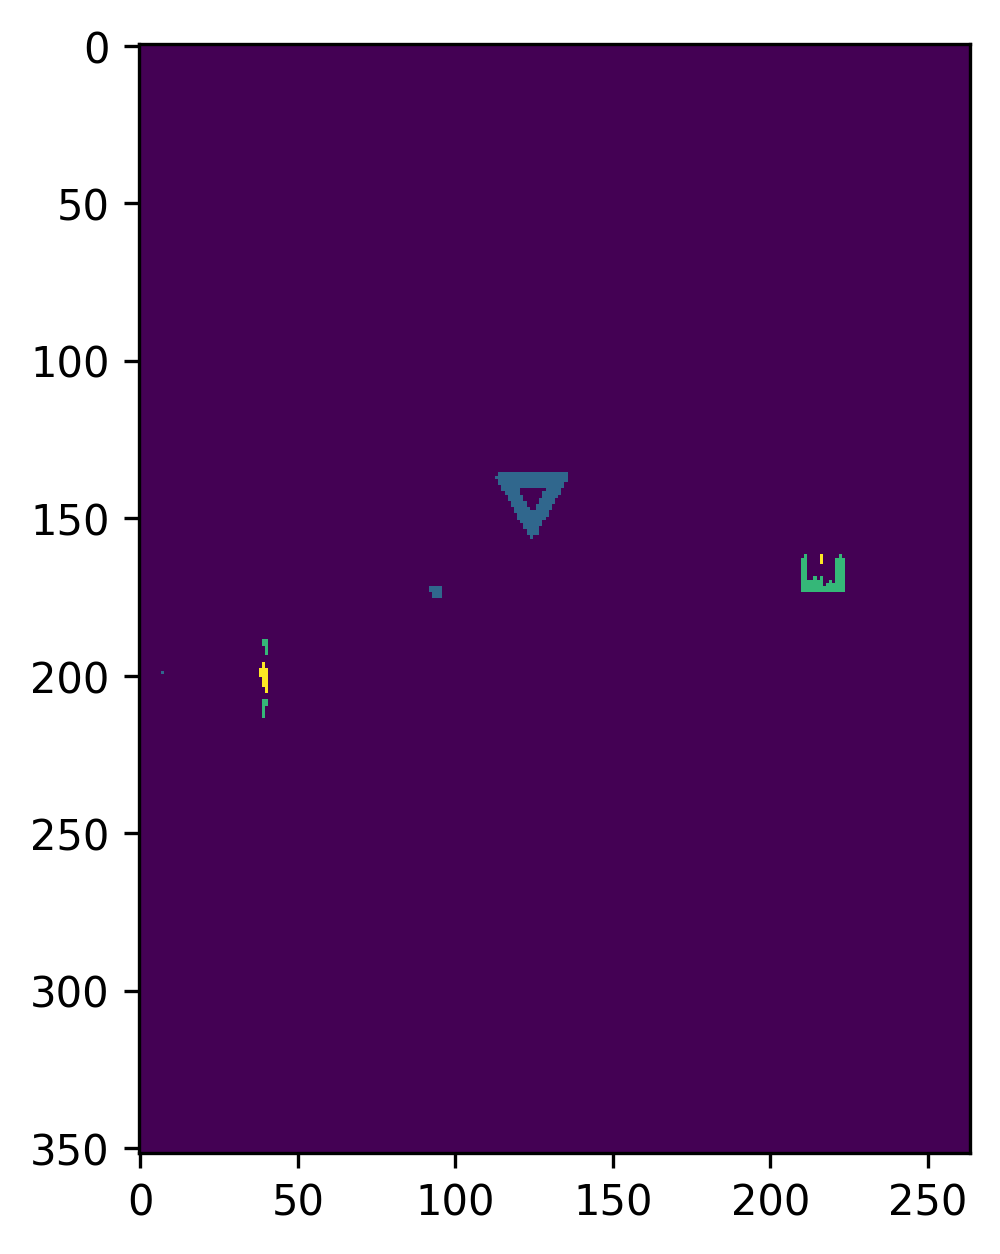

current_img:


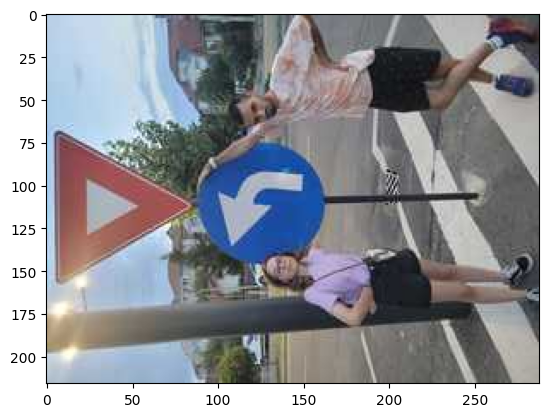

thin: red: 0.9433 	white: 0.5097 	score: 0.7265
thick: red: 0.8099 	white: 0.9967 	score: 0.9033


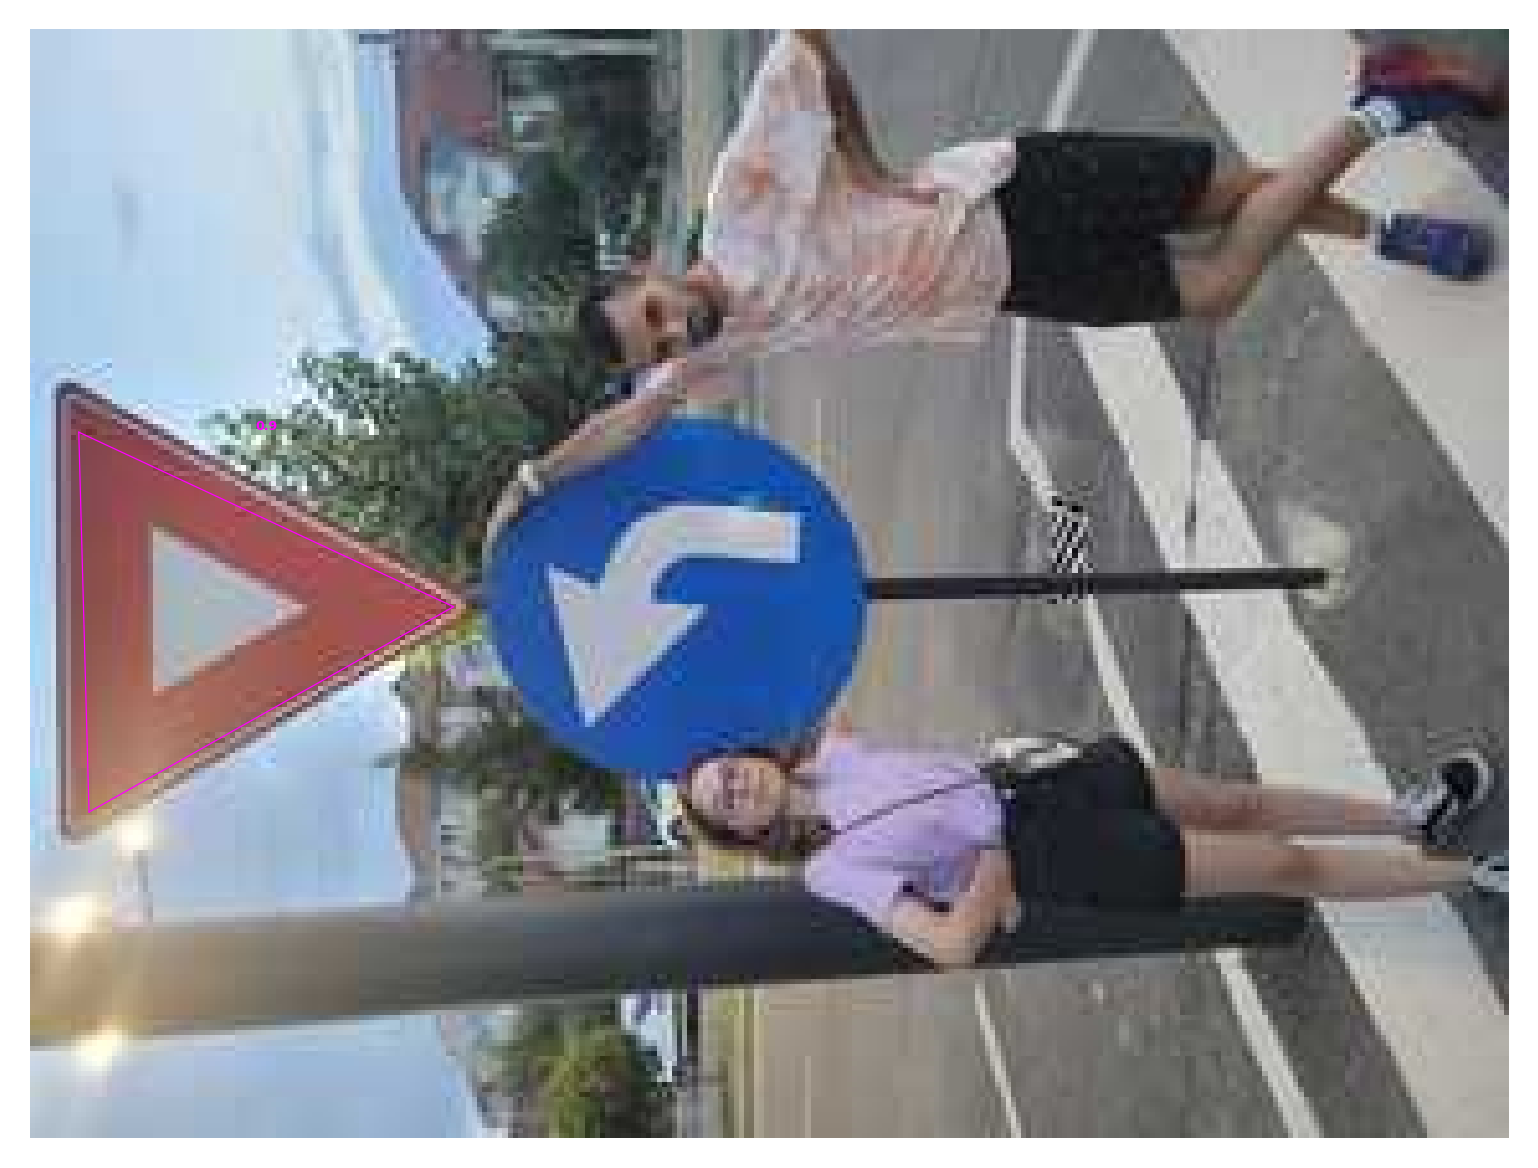

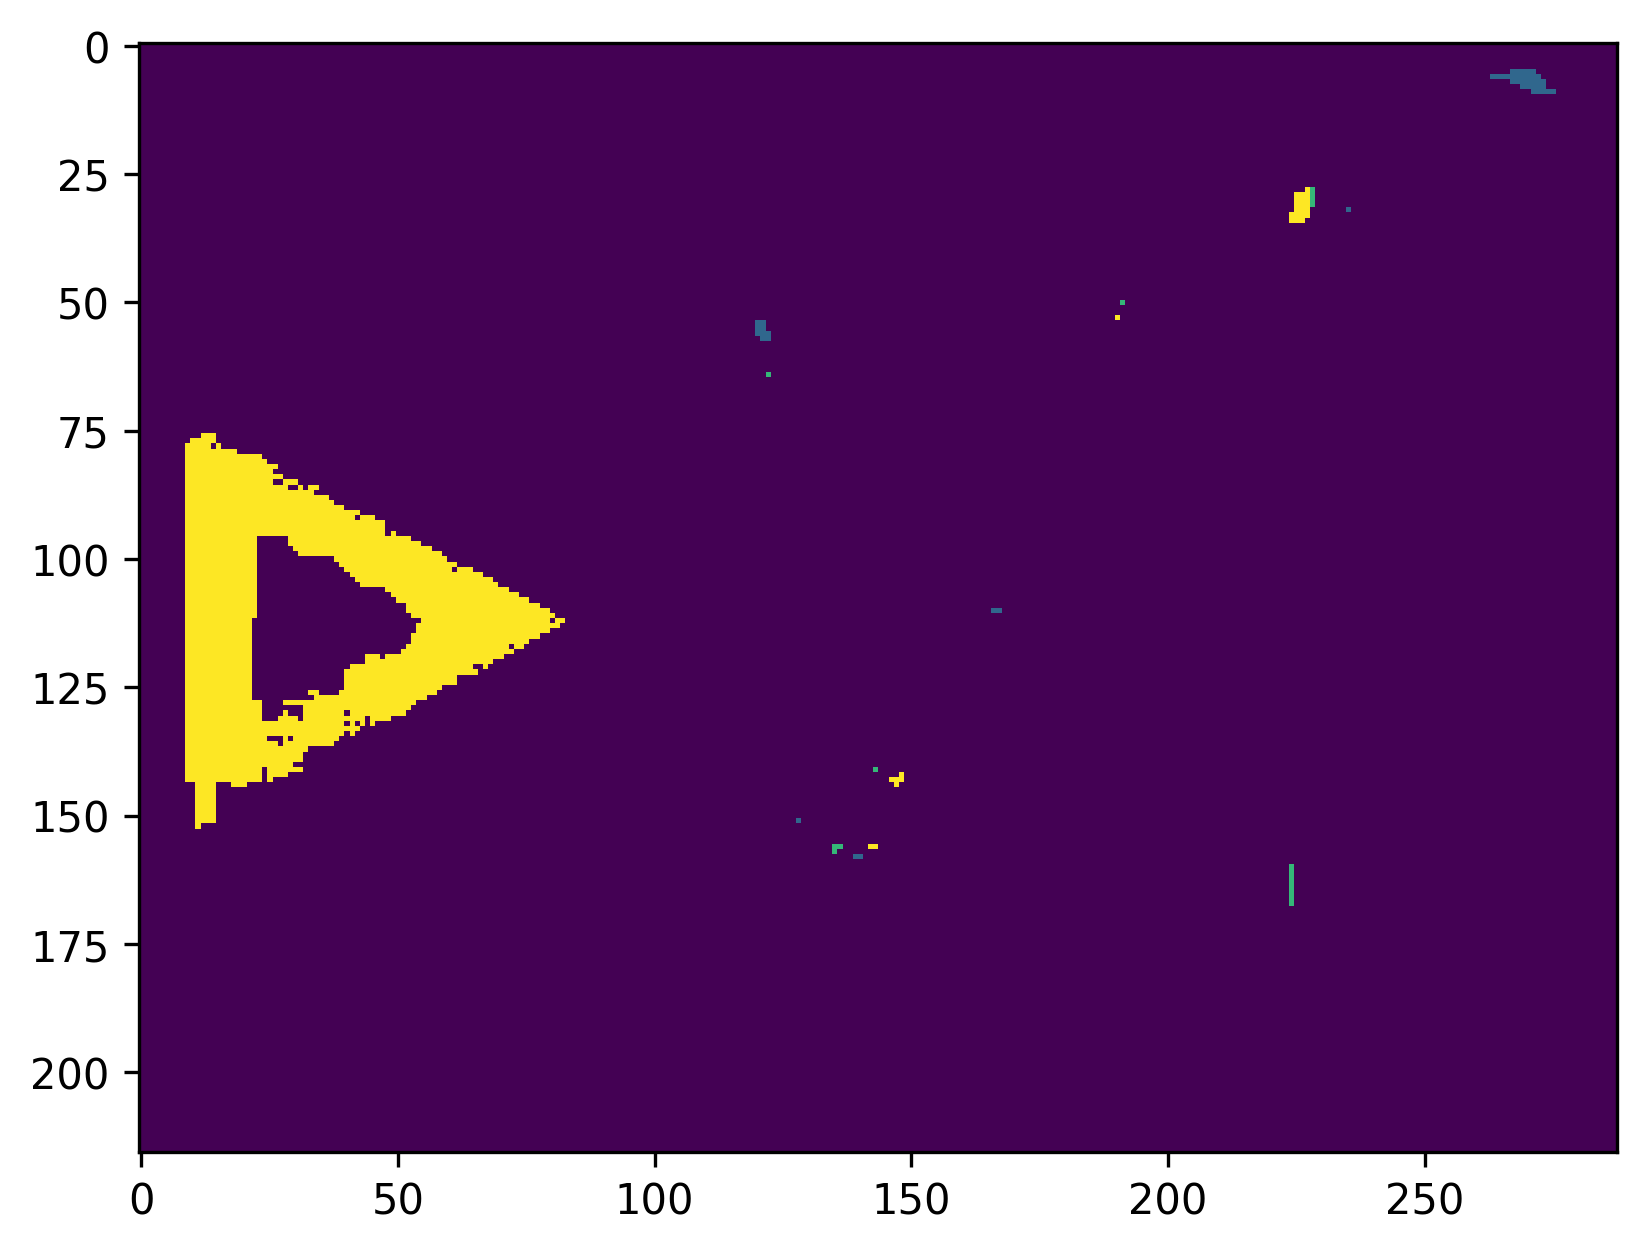

current_img:


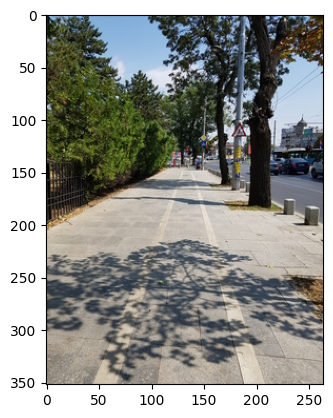

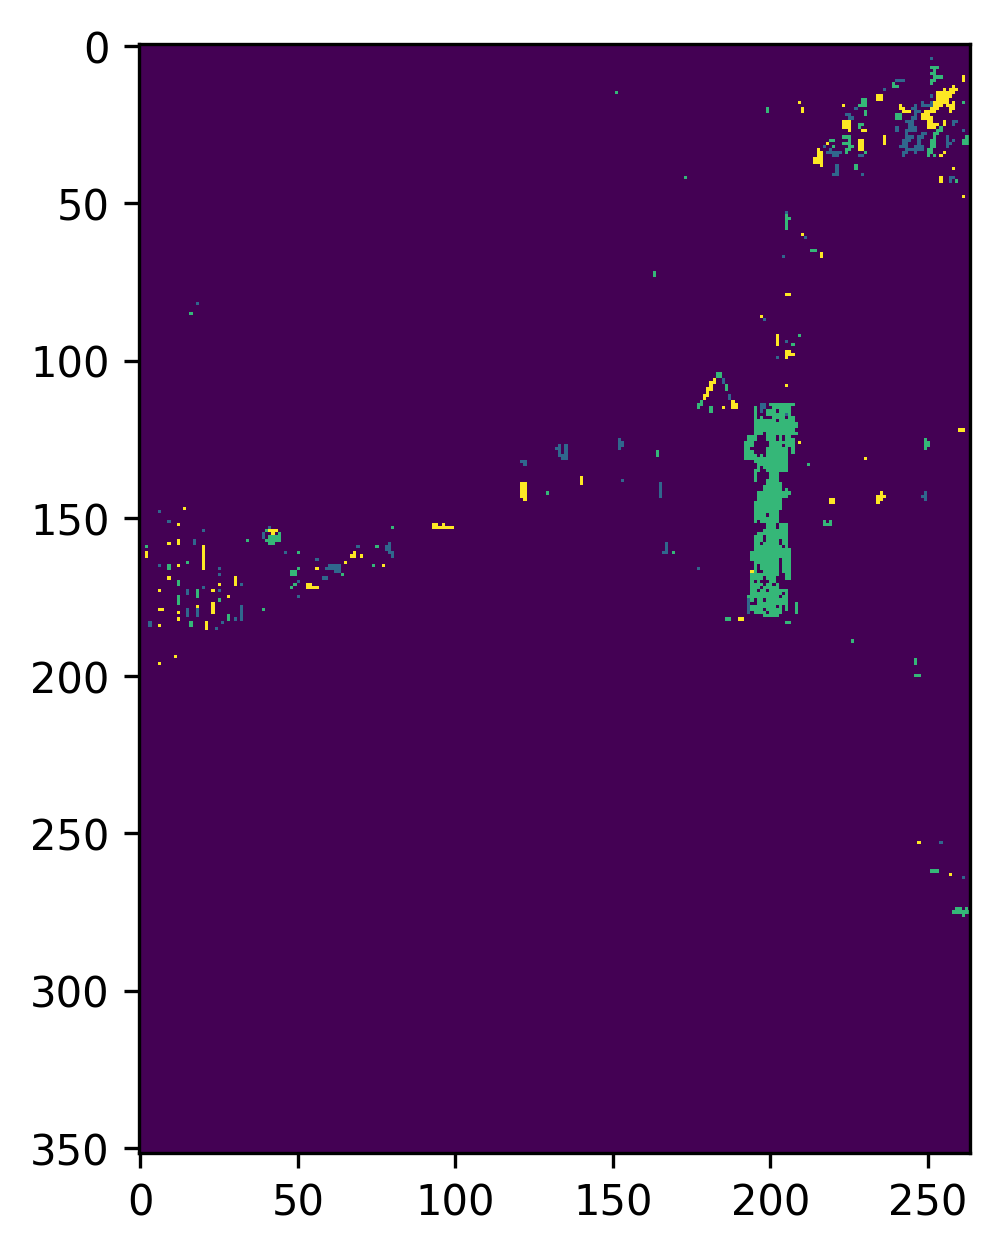

current_img:


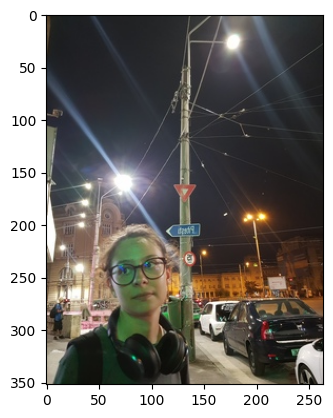

thin: red: 1.1181 	white: 0.0 	score: 0.5
thick: red: 0.969 	white: 0.0 	score: 0.4845
thin: red: 0.6607 	white: 0.263 	score: 0.4619
thick: red: 0.7287 	white: 0.0 	score: 0.3644


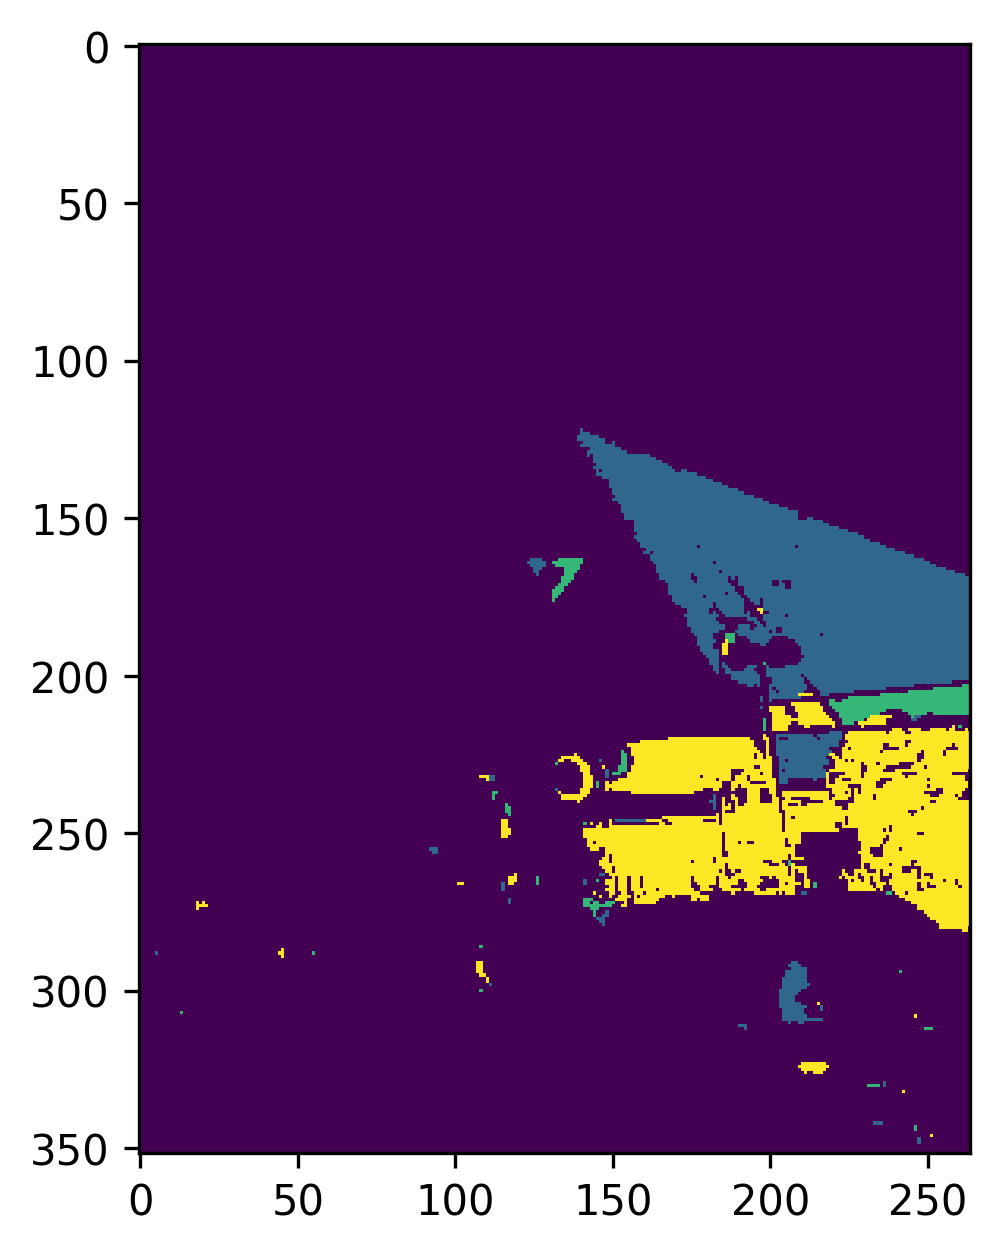

current_img:


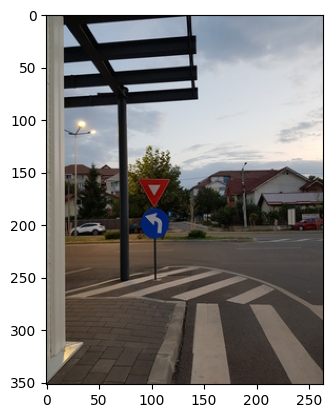

thin: red: 1.0169 	white: 0.2621 	score: 0.6311
thick: red: 0.9866 	white: 0.9104 	score: 0.9485


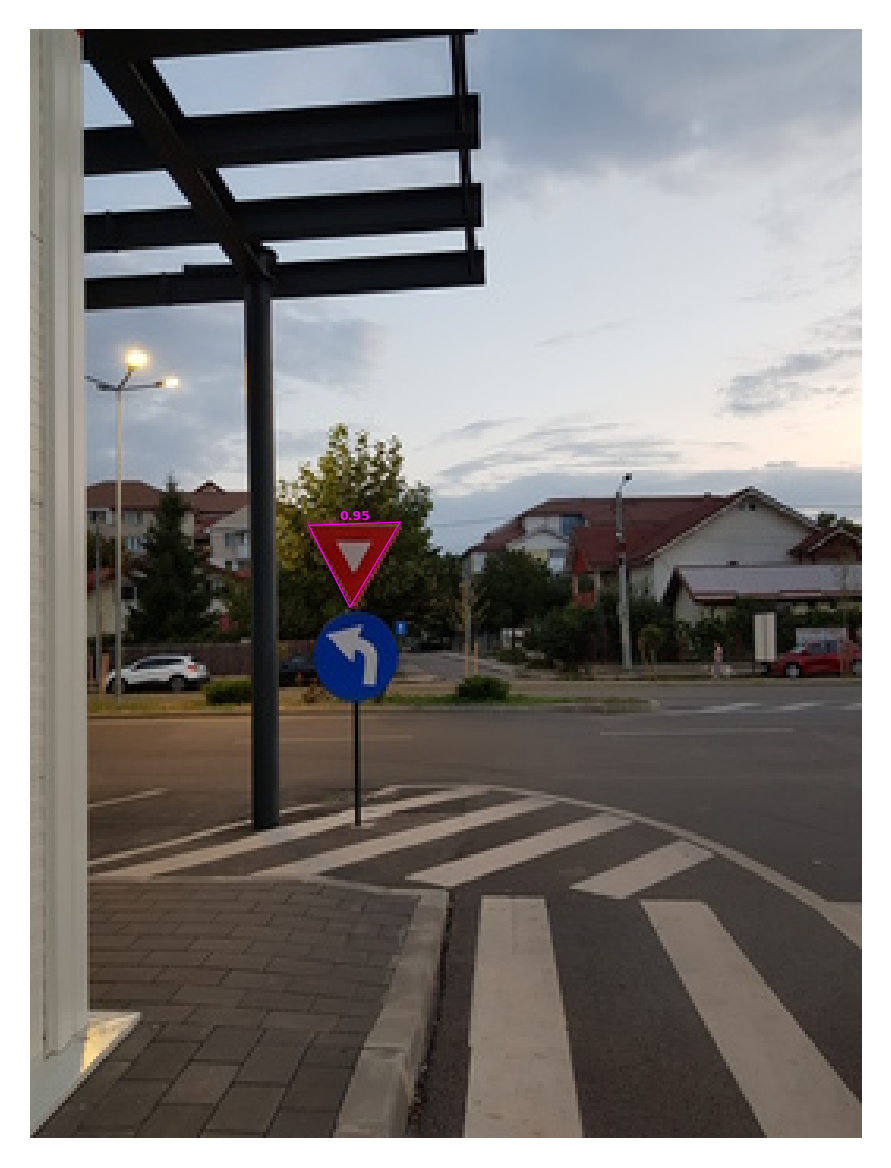

thin: red: 0.8103 	white: 0.0 	score: 0.4052
thick: red: 0.782 	white: 0.0 	score: 0.391


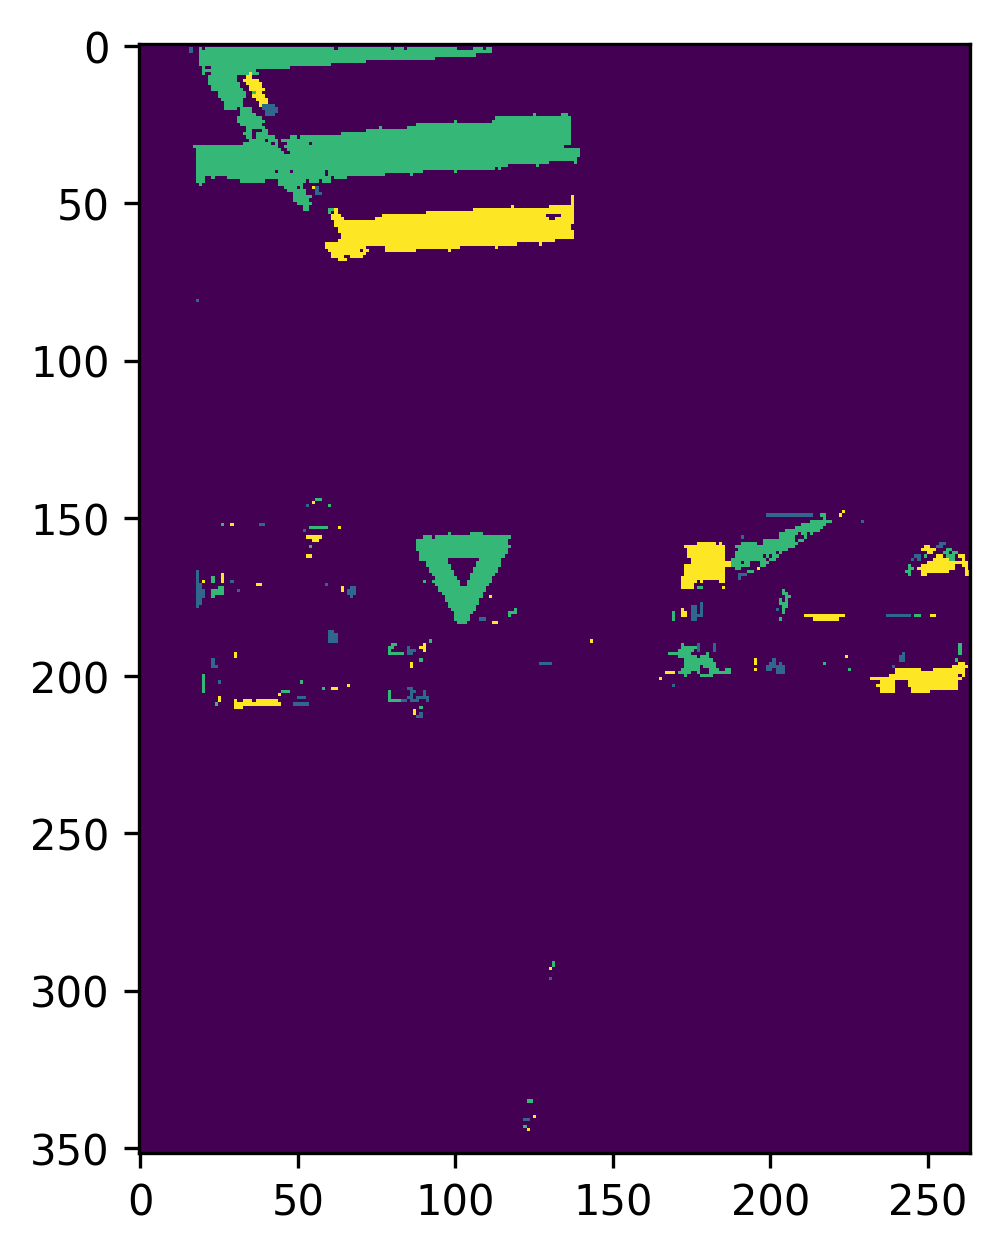

current_img:


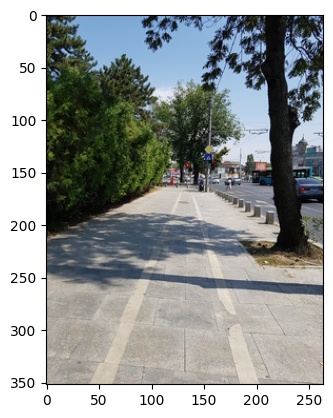

thin: red: 0.8306 	white: 0.1929 	score: 0.5117
thick: red: 1.0306 	white: 0.789 	score: 0.8945


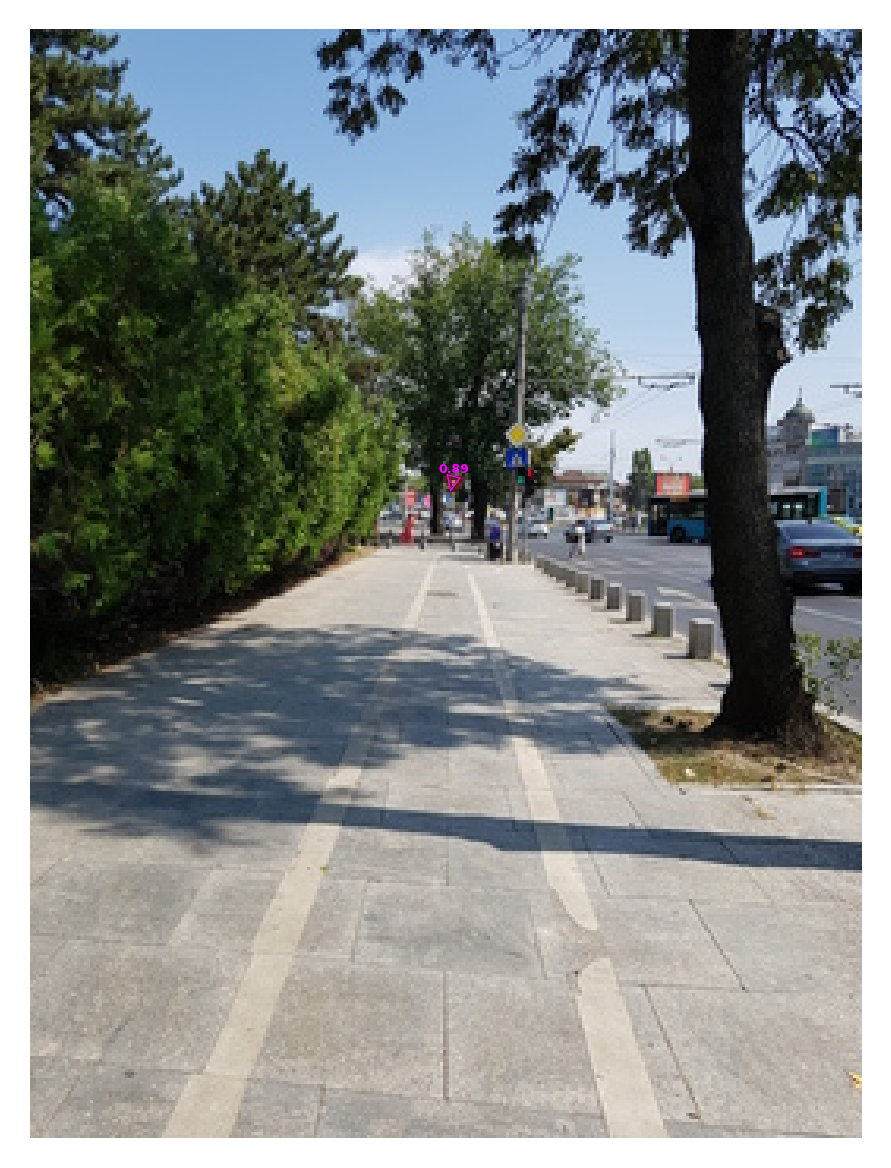

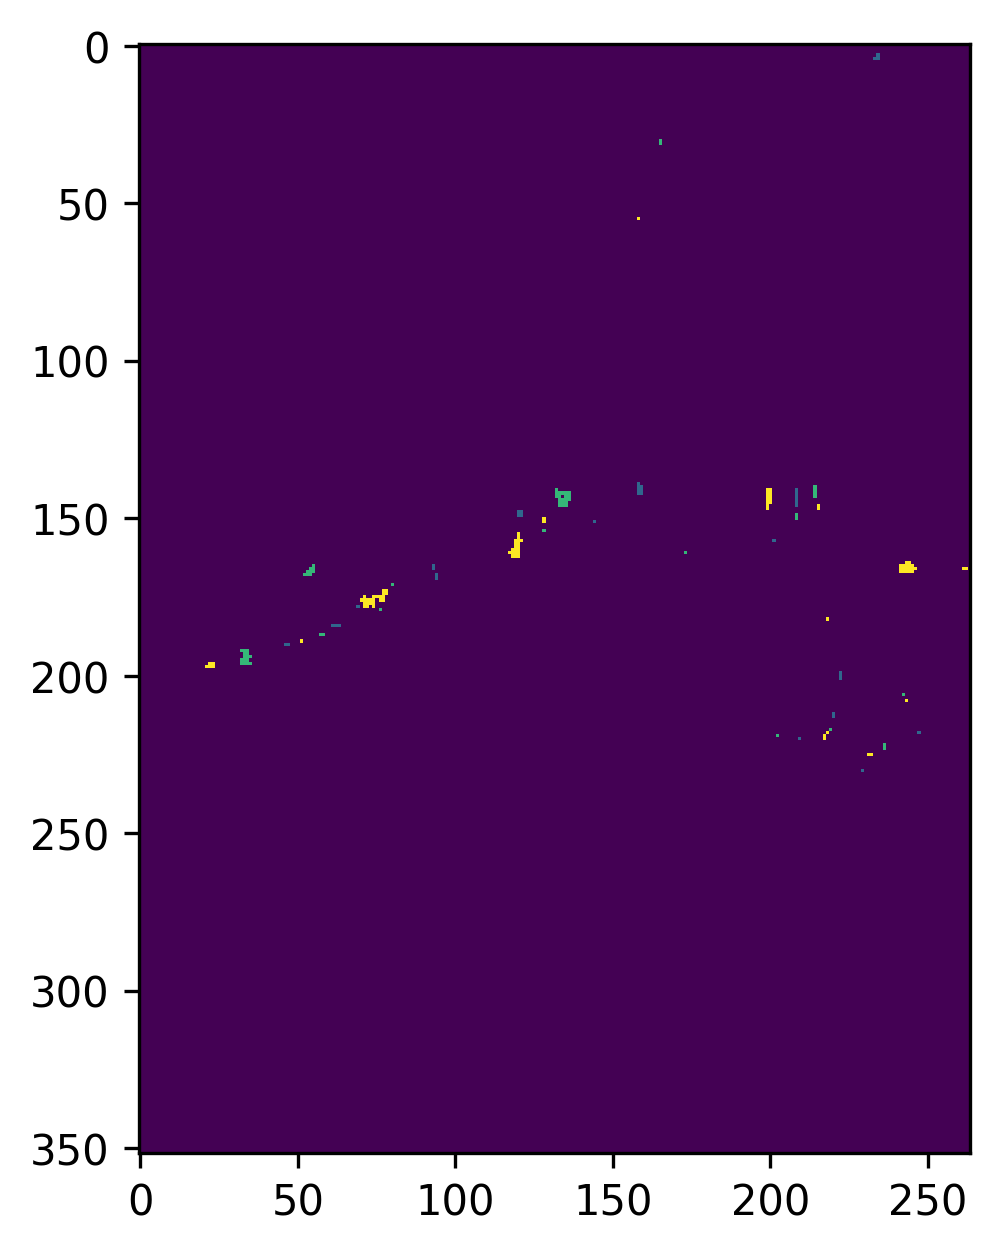

current_img:


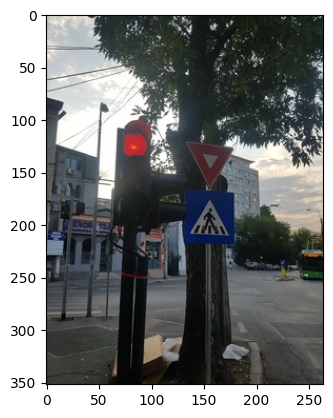

thin: red: 0.9926 	white: 0.0 	score: 0.4963
thick: red: 1.0004 	white: 0.0 	score: 0.5
thin: red: 0.9727 	white: 0.3041 	score: 0.6384
thick: red: 0.8769 	white: 0.9833 	score: 0.9301


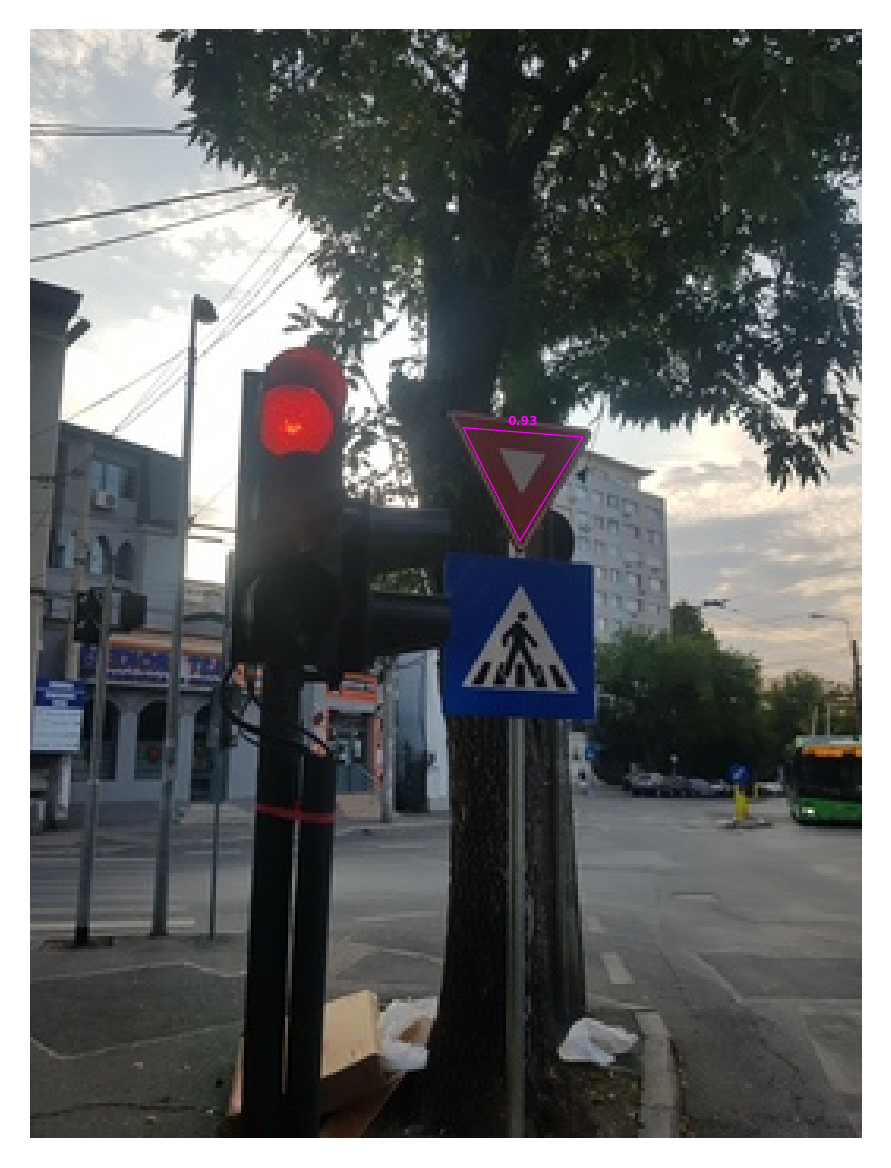

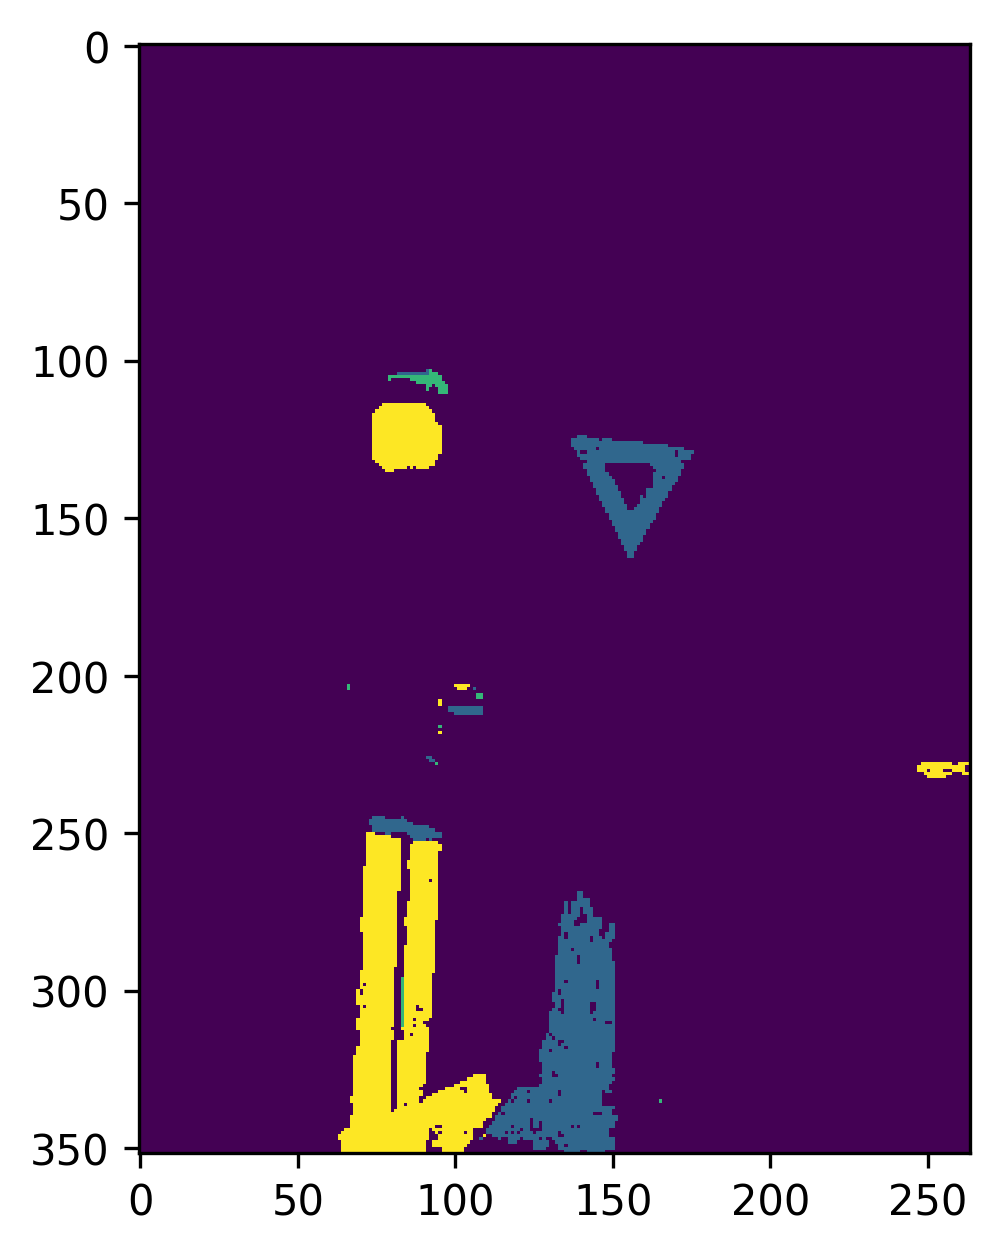

current_img:


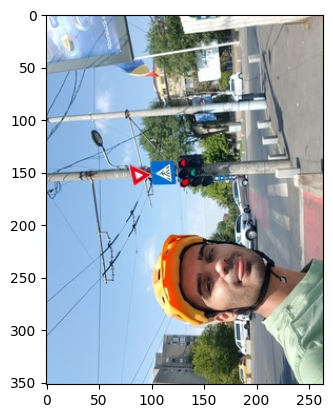

thin: red: 1.2214 	white: 0.0 	score: 0.5
thick: red: 1.0778 	white: 0.0 	score: 0.5
thin: red: 1.0081 	white: 0.3495 	score: 0.6747
thick: red: 0.9294 	white: 0.9148 	score: 0.9221


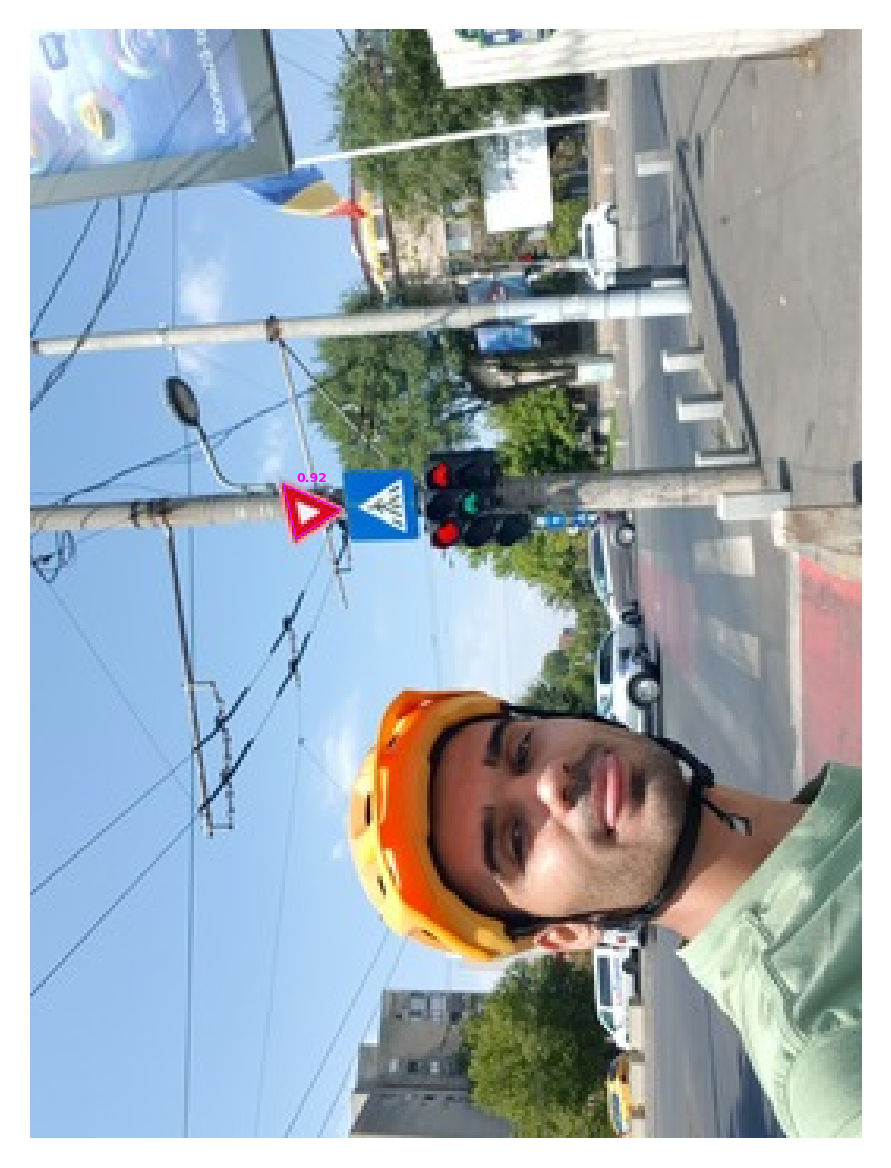

thin: red: 0.969 	white: 0.0 	score: 0.4845
thick: red: 1.0688 	white: 0.0 	score: 0.5


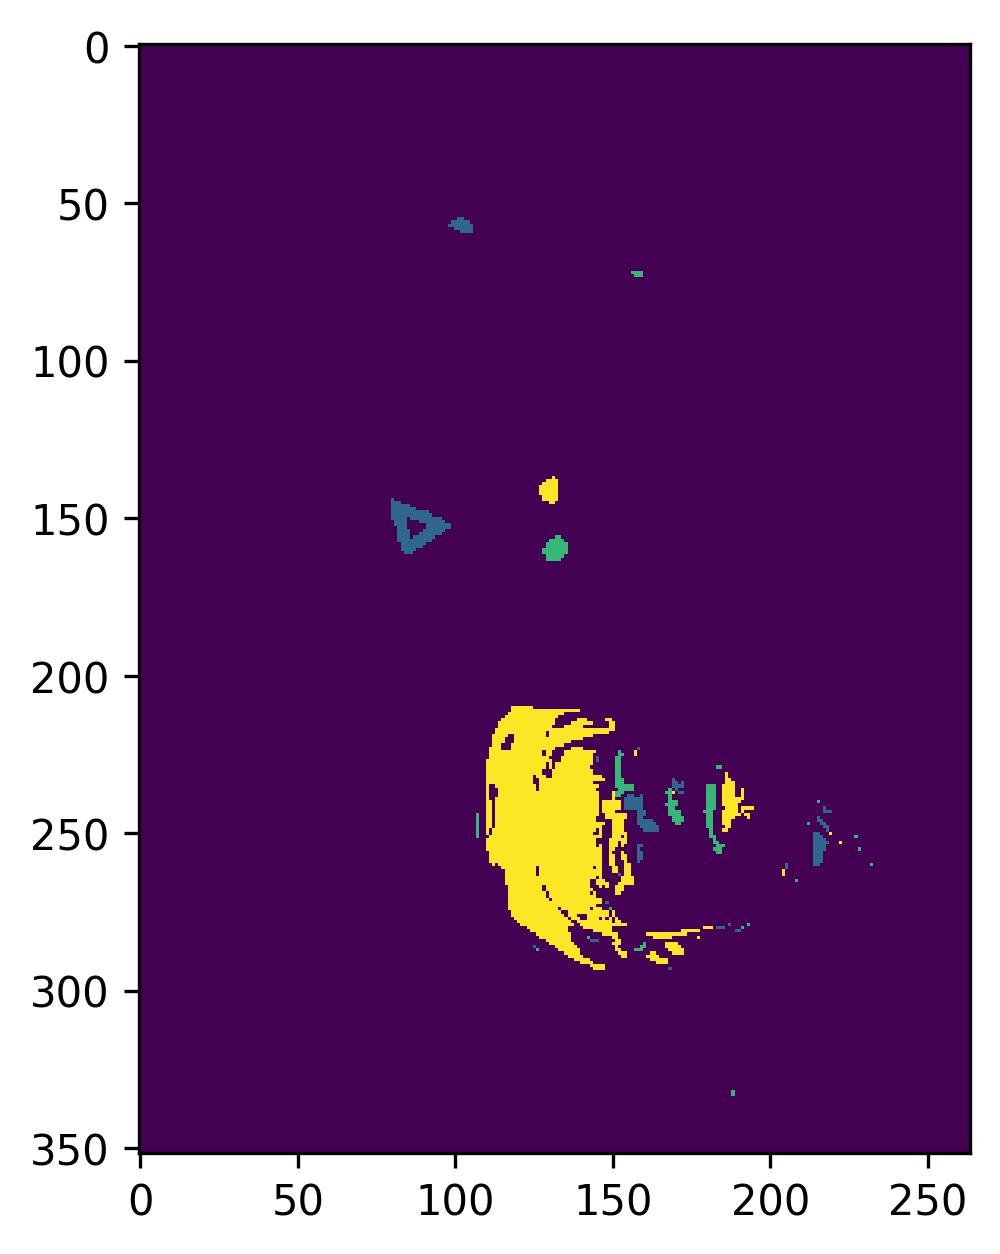

current_img:


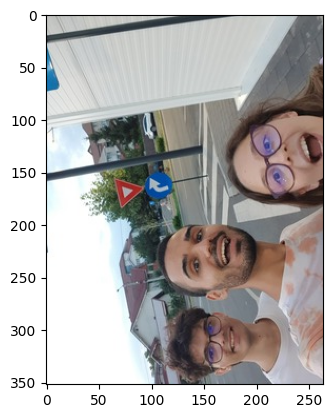

thin: red: 1.0228 	white: 0.3929 	score: 0.6965
thick: red: 0.9119 	white: 0.9644 	score: 0.9381


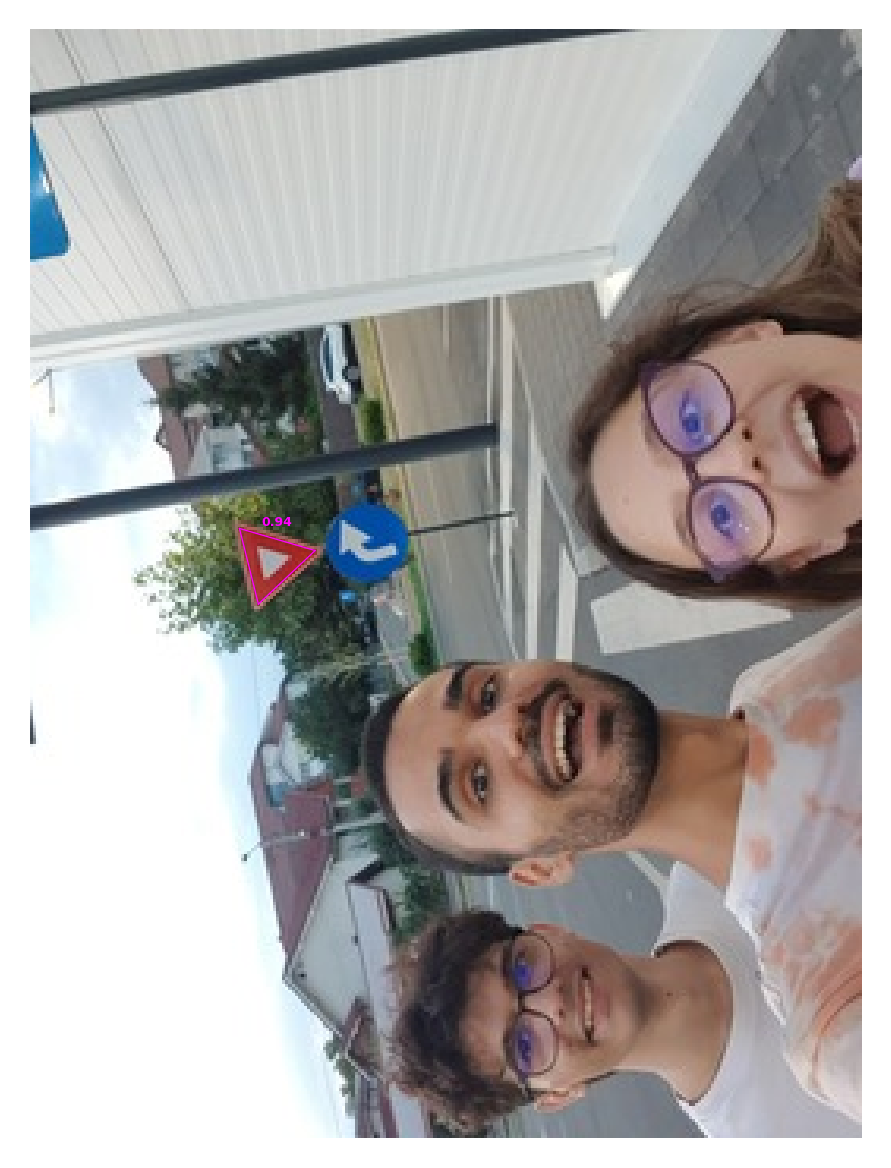

thin: red: 0.8852 	white: 0.0 	score: 0.4426
thick: red: 0.8558 	white: 0.0 	score: 0.4279
thin: red: 0.7329 	white: 0.0 	score: 0.3664
thick: red: 0.8083 	white: 0.0 	score: 0.4042
thin: red: 1.3843 	white: 0.0 	score: 0.5
thick: red: 1.1451 	white: 0.0 	score: 0.5


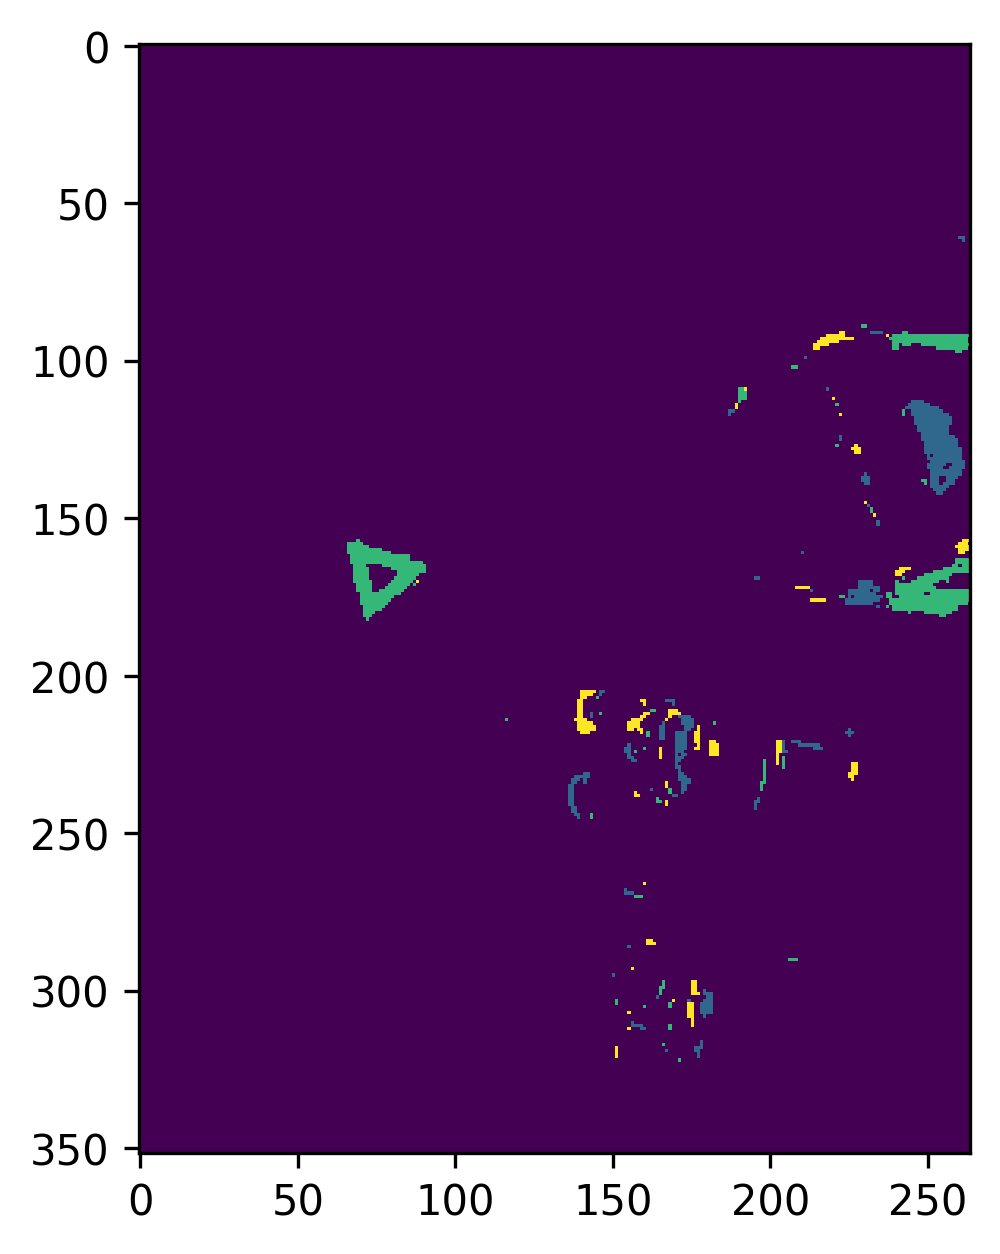

current_img:


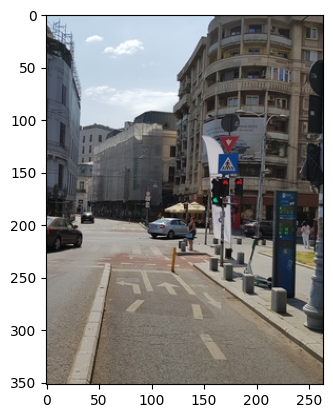

thin: red: 1.147 	white: 0.3491 	score: 0.6745
thick: red: 0.9379 	white: 1.1272 	score: 0.969


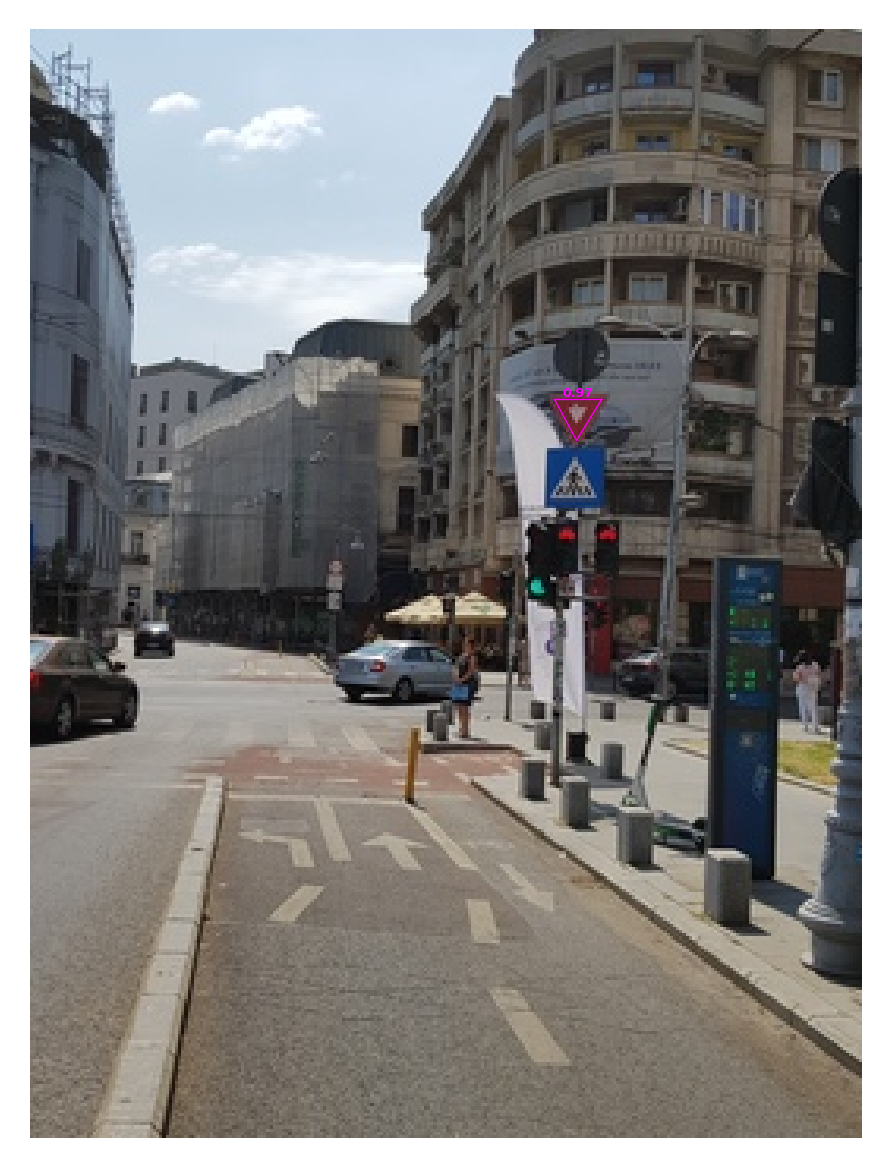

thin: red: 1.2112 	white: 0.0 	score: 0.5
thick: red: 0.9543 	white: 0.0 	score: 0.4771
thin: red: 0.9836 	white: 0.0 	score: 0.4918
thick: red: 1.0005 	white: 0.0 	score: 0.5
thin: red: 1.0047 	white: 0.0 	score: 0.5
thick: red: 0.9789 	white: 0.0 	score: 0.4895


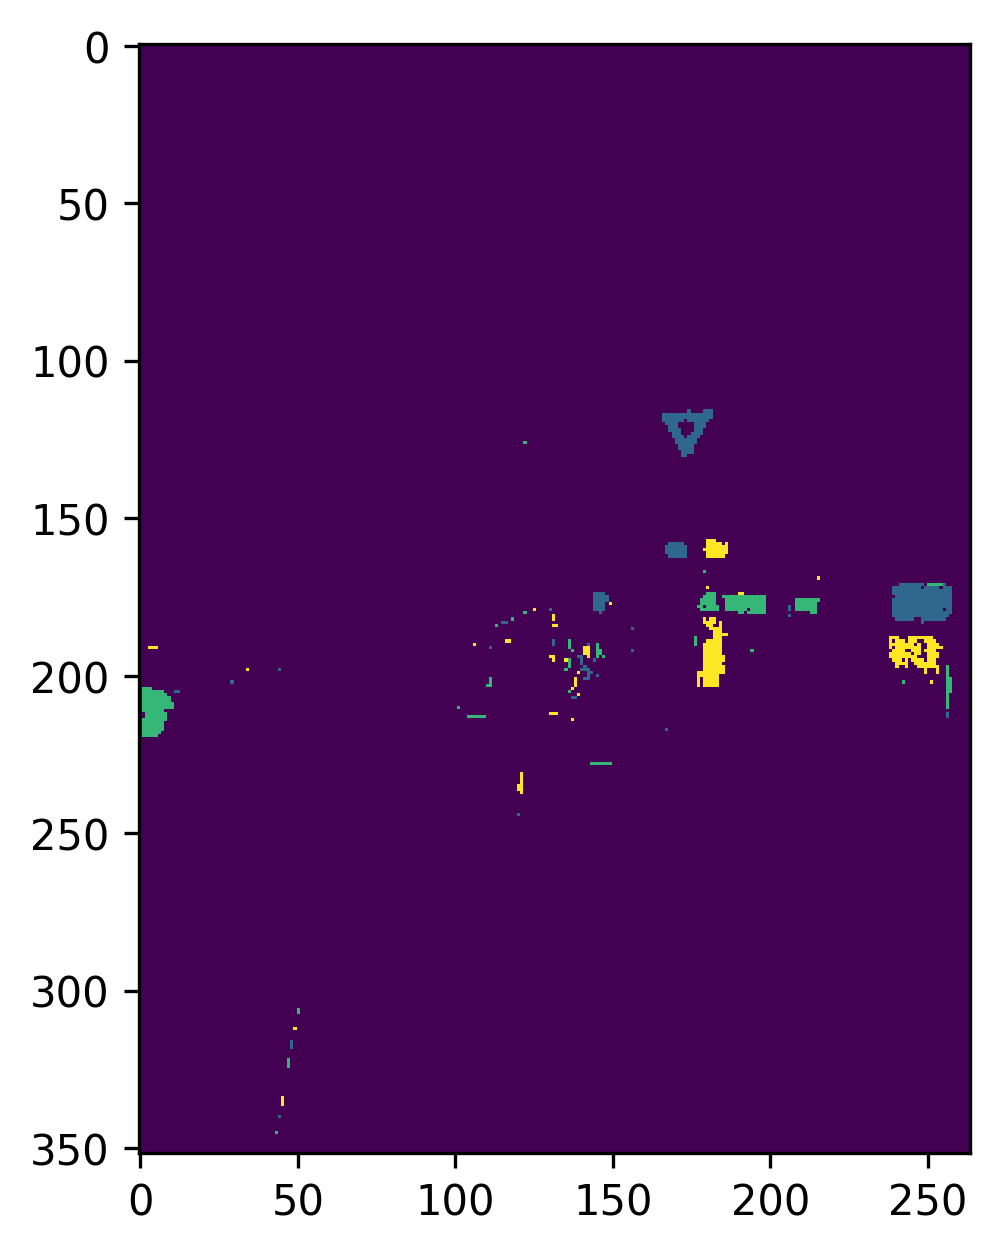

current_img:


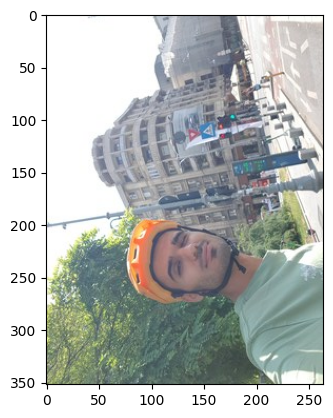

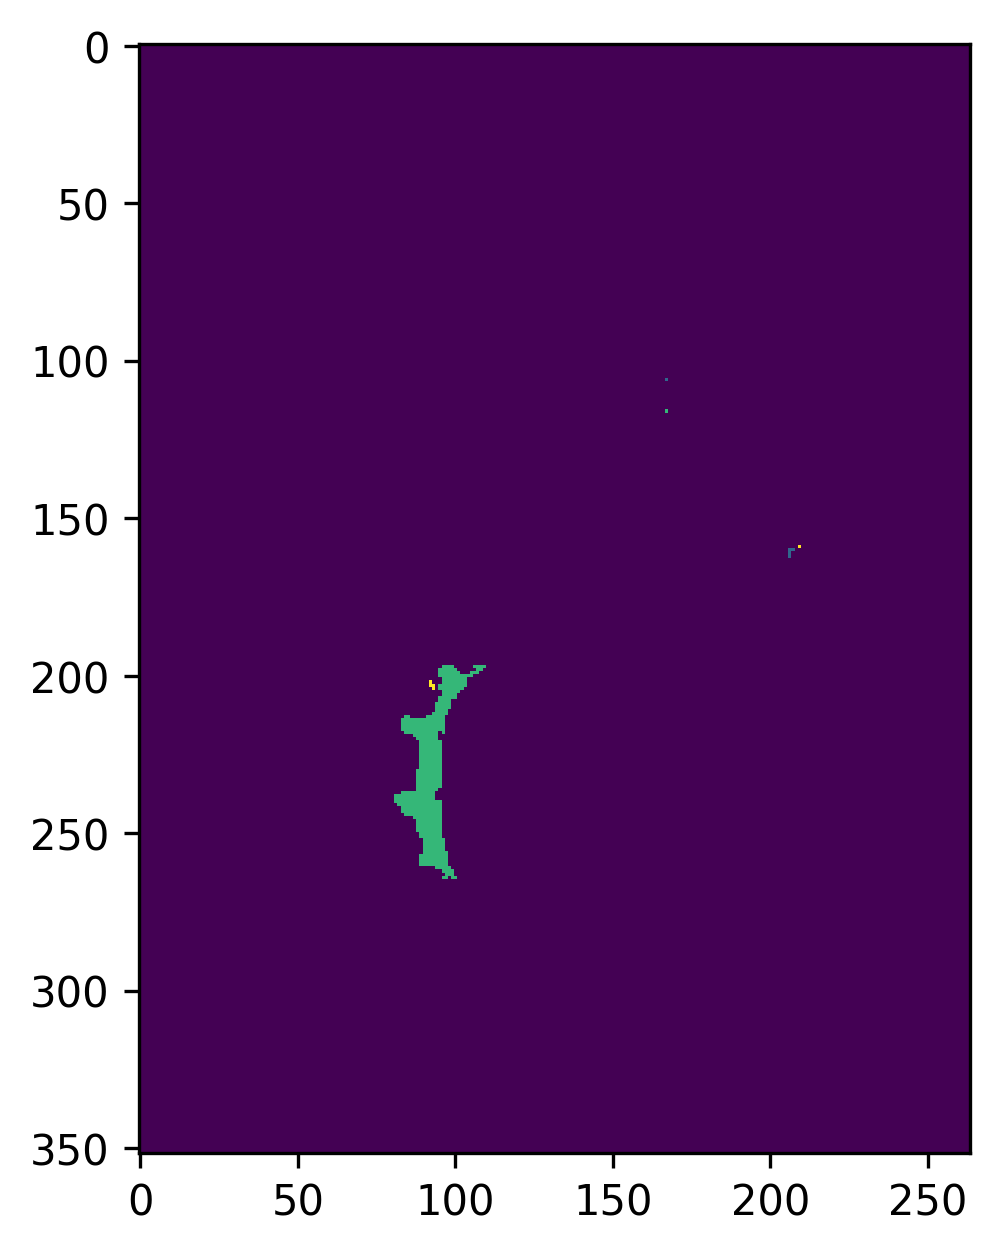

avg_score 0.9328319341275921
detections 10


In [ ]:
print(len(gw_images))
scores = []
for i in range(0, len(gw_images)):
    print("current_img:")
    plt.imshow(gw_images[i])
    plt.show()
    current_score = detect_gw(gw_images[i])
    if current_score > 0:
        scores.append(current_score)

print("avg_score", np.sum(scores) / len(scores))
print("detections", len(scores))

# avg_score 0.959260741144003
# detections 10